In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import csv
import requests
from bs4 import BeautifulSoup
import requests

In [2]:
# Link to Data Used = https://github.com/nytimes/covid-19-data

In [3]:
# Let's try to take out the download step by using requests

url = 'https://github.com/nytimes/covid-19-data/blob/master/us-states.csv'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

table = soup.find("table", {"class":"js-csv-data"})

total_us_data = pd.read_html(str(table))[0]

total_us_data.drop(columns='Unnamed: 0', inplace=True)

total_us_data.to_csv('most_recent_data.csv')

In [4]:
# Always have at least one of these marked out
# total_us_data = pd.read_csv('NYT-US-Data/us-states-2020-04-27.csv').drop(columns='Unnamed: 0')

In [5]:
# let's give the data a look
total_us_data.head()

date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0

In [6]:
# Let's check for nulls
total_us_data.isnull().sum()

date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

In [7]:
# Let's check on the different states
total_us_data.state.unique()

array(['Washington', 'Illinois', 'California', 'Arizona', 'Massachusetts',
       'Wisconsin', 'Texas', 'Nebraska', 'Utah', 'Oregon', 'Florida',
       'New York', 'Rhode Island', 'Georgia', 'New Hampshire',
       'North Carolina', 'New Jersey', 'Colorado', 'Maryland', 'Nevada',
       'Tennessee', 'Hawaii', 'Indiana', 'Kentucky', 'Minnesota',
       'Oklahoma', 'Pennsylvania', 'South Carolina',
       'District of Columbia', 'Kansas', 'Missouri', 'Vermont',
       'Virginia', 'Connecticut', 'Iowa', 'Louisiana', 'Ohio', 'Michigan',
       'South Dakota', 'Arkansas', 'Delaware', 'Mississippi',
       'New Mexico', 'North Dakota', 'Wyoming', 'Alaska', 'Maine',
       'Alabama', 'Idaho', 'Montana', 'Puerto Rico', 'Virgin Islands',
       'Guam', 'West Virginia', 'Northern Mariana Islands'], dtype=object)

### Let's Check on and Add Some Data

In [8]:
# Date isn't DateTime Yet
total_us_data.dtypes

date      object
state     object
fips       int64
cases      int64
deaths     int64
dtype: object

In [9]:
# Fixed it
total_us_data['date'] = pd.to_datetime(total_us_data['date'])

In [10]:
# Took me a few days, but I figured out how to do pct_change with groupby
# This will show the percent change in cases by day
total_us_data['percent_change'] = total_us_data.groupby('state').cases.pct_change()
total_us_data['percent_change'].fillna(0, inplace=True)

In [11]:
# Let's add a difference column
total_us_data['change_in_cases'] = total_us_data.groupby('state')['cases'].diff()

In [12]:
# Looks good
total_us_data.head()

date       state  fips  cases  deaths  percent_change  change_in_cases
0 2020-01-21  Washington    53      1       0             0.0              NaN
1 2020-01-22  Washington    53      1       0             0.0              0.0
2 2020-01-23  Washington    53      1       0             0.0              0.0
3 2020-01-24    Illinois    17      1       0             0.0              NaN
4 2020-01-24  Washington    53      1       0             0.0              0.0

In [13]:
# Let's try to add a few moving averages
# Change in Cases shortened to CIC
# Simple Moving Average shortened to SMA
total_us_data['cic_7_day_sma'] = total_us_data.groupby('state')['change_in_cases'].transform(lambda x: x.rolling(7, 1).mean())
total_us_data['cic_10_day_sma'] = total_us_data.groupby('state')['change_in_cases'].transform(lambda x: x.rolling(10, 1).mean())
total_us_data['cic_21_day_sma'] = total_us_data.groupby('state')['change_in_cases'].transform(lambda x: x.rolling(21, 1).mean())

In [14]:
total_us_data

date          state  fips   cases  deaths  percent_change  \
0     2020-01-21     Washington    53       1       0        0.000000   
1     2020-01-22     Washington    53       1       0        0.000000   
2     2020-01-23     Washington    53       1       0        0.000000   
3     2020-01-24       Illinois    17       1       0        0.000000   
4     2020-01-24     Washington    53       1       0        0.000000   
...          ...            ...   ...     ...     ...             ...   
14529 2020-11-21       Virginia    51  215679    3938        0.011006   
14530 2020-11-21     Washington    53  148691    2738        0.009779   
14531 2020-11-21  West Virginia    54   39598     658        0.029054   
14532 2020-11-21      Wisconsin    55  372219    3155        0.019248   
14533 2020-11-21        Wyoming    56   27410     176        0.010358   

       change_in_cases  cic_7_day_sma  cic_10_day_sma  cic_21_day_sma  
0                  NaN            NaN             NaN             NaN  
1                  0.0       0.000000             0.0        0.000000  
2                  0.0       0.000000             0.0        0.000000  
3                  NaN            NaN             NaN             NaN  
4                  0.0       0.000000             0.0        0.000000  
...                ...            ...             ...             ...  
14529           2348.0    2125.714286          1917.3     1642.333333  
14530           1440.0    2154.142857          2180.5     1719.571429  
14531           1118.0     972.285714           939.7      720.857143  
14532           7029.0    6945.000000          7087.0     6397.571429  
14533            281.0     789.857143           803.6      672.000000  

[14534 rows x 10 columns]

In [15]:
# Let's read this in to make the graphs easier
state_action = pd.read_csv('state_action.csv')
state_action = state_action.set_index('state')

In [16]:
# And let's convert these back to datetime
state_action.state_of_emergency = pd.to_datetime(state_action.state_of_emergency)
state_action.stay_at_home = pd.to_datetime(state_action.stay_at_home)

### Separating the Data by State

In [17]:
# Let's make a funciton to seperate these
def state_info(state):
    data = total_us_data[total_us_data.state == state]
    data.date = pd.to_datetime(data.date)
    data = data.set_index(data.date)
#     data['percent_change'] = data.cases.pct_change()
#     data.percent_change.fillna(0, inplace=True)
    return data.drop(labels='date', axis=1)

In [18]:
# Function Test
state_info('Northern Mariana Islands').head()

C:\Users\nolan\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


state  fips  cases  deaths  percent_change  \
date                                                                        
2020-03-28  Northern Mariana Islands    69      2       0             0.0   
2020-03-29  Northern Mariana Islands    69      2       0             0.0   
2020-03-30  Northern Mariana Islands    69      2       0             0.0   
2020-03-31  Northern Mariana Islands    69      2       0             0.0   
2020-04-01  Northern Mariana Islands    69      6       1             2.0   

            change_in_cases  cic_7_day_sma  cic_10_day_sma  cic_21_day_sma  
date                                                                        
2020-03-28              NaN            NaN             NaN             NaN  
2020-03-29              0.0            0.0             0.0             0.0  
2020-03-30              0.0            0.0             0.0             0.0  
2020-03-31              0.0            0.0             0.0             0.0  
2020-04-01              4.0            1.0             1.0             1.0

In [19]:
# Don't know how to make a function to do this, so here we go
washington_data = state_info('Washington')
illinois_data = state_info('Illinois')
california_data = state_info('California')
arizona_data = state_info('Arizona')
massachusetts_data = state_info('Massachusetts')
wisconsin_data = state_info('Wisconsin')
texas_data = state_info('Texas')
nebraska_data = state_info('Nebraska')
utah_data = state_info('Utah')
oregon_data = state_info('Oregon')
florida_data = state_info('Florida')
new_york_data = state_info('New York')
rhode_island_data = state_info('Rhode Island')
georgia_data = state_info('Georgia')
new_hampshire_data = state_info('New Hampshire')
north_carolina_data = state_info('North Carolina')
new_jersey_data = state_info('New Jersey')
colorado_data = state_info('Colorado')
maryland_data = state_info('Maryland')
nevada_data = state_info('Nevada')
tennessee_data = state_info('Tennessee')
hawaii_data = state_info('Hawaii')
indiana_data = state_info('Indiana')
kentucky_data = state_info('Kentucky')
minnesota_data = state_info('Minnesota')
oklahoma_data = state_info('Oklahoma')
pennsylvania_data = state_info('Pennsylvania')
south_carolina_data = state_info('South Carolina')
dc_data = state_info('District of Columbia')
kansas_data = state_info('Kansas')
missouri_data = state_info('Missouri')
vermont_data = state_info('Vermont')
virginia_data = state_info('Virginia')
connecticut_data = state_info('Connecticut')
iowa_data = state_info('Iowa')
louisiana_data = state_info('Louisiana')
ohio_data = state_info('Ohio')
michigan_data = state_info('Michigan')
south_dakota_data = state_info('South Dakota')
arkansas_data = state_info('Arkansas')
delaware_data = state_info('Delaware')
mississippi_data = state_info('Mississippi')
new_mexico_data = state_info('New Mexico')
north_dakota_data = state_info('North Dakota')
wyoming_data = state_info('Wyoming')
alaska_data = state_info('Alaska')
maine_data = state_info('Maine')
alabama_data = state_info('Alabama')
idaho_data = state_info('Idaho')
montana_data = state_info('Montana')
puerto_rico_data = state_info('Puerto Rico')
virgin_islands_data = state_info('Virgin Islands')
guam_data = state_info('Guam')
west_virginia_data = state_info('West Virginia')
north_mariana_islands_data = state_info('Northern Mariana Islands')
american_samoa_data = state_info('American Samoa')

In [20]:
# Changing the Pandas Settings Real Quick
pd.options.display.min_rows = 50

In [21]:
pd.options.display.min_rows

50

# Function That Makes The Graphs

In [22]:
# This will be the main graph funciton
def daily_change(state, title=None, state_of_emergency_declaration=None, 
                 stay_at_home_order=None, end_of_stay_at_home=None,
                 easter=None, fourth_of_july=None):
    
    plt.figure(figsize=(16, 9))
    
    if title == None:
        plt.title(label=f"{state.state[0]} Currently Has {state.cases[-1]} Cases In Total", size=24)
    else:
        plt.title(title, size=24)
    
    plt.plot(state.change_in_cases, label='Daily Change')
    plt.plot(state.cic_7_day_sma, label='7 Day Moving Average')
    
    state_of_emergency = state_action.state_of_emergency[state.state[0]]
    stay_at_home = state_action.stay_at_home[state.state[0]]
    week = dt.timedelta(days=7)
    
    # This adds the State of Emergency Declaration Date
    if state_of_emergency_declaration != None:
        if not pd.isna(state_of_emergency):
            plt.vlines(x=state_of_emergency, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='purple', label='State of Emergency Declaration')
            plt.vlines(x=state_of_emergency+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='purple', label='One Week After State of Emergency')
    
    # This add's the Stay at Home Order Date
    # The if not is to weed out states with no Stay at Home Orders
    if stay_at_home_order != None:
        if not pd.isna(stay_at_home):
            plt.vlines(x=state_action.stay_at_home[state.state[0]], ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='green', label='Stay At Home Order Enacted')
            plt.vlines(x=state_action.stay_at_home[state.state[0]]+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='green', label='One Week After Stay At Home')
    
    # Since Georgia and Texas are lifting their Stay at Home Orders, I have ot stay adding this
    if end_of_stay_at_home != None:
        plt.vlines(x=end_of_stay_at_home, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='red', label='End of Stay At Home Order')
        plt.vlines(x=end_of_stay_at_home+week, ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='red', label='One Week After End of Stay At Home')
    
    
    # This adds Easter's markers, so it will noramally not be used
    if easter != None:
        plt.vlines(x=dt.date(2020, 4, 12), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='gold', label='Easter Sunday')
        plt.vlines(x=dt.date(2020, 4, 19), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='gold', label='One Week After Easter')
    
    
    # This adds the 4th of July's markers
    if fourth_of_july != None:
        plt.vlines(x=dt.date(2020, 7, 4), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyles='solid', color='navy', label='4th of July')
        plt.vlines(x=dt.date(2020, 7, 11), ymin=state.change_in_cases.min(), ymax=state.change_in_cases.max(), linestyle='dashdot', color='navy', label='One Week After the 4th')
    
    
    # This will add text at the end of the line indicating the current number of cases
    plt.text(x=state.index[-1], y=(state.change_in_cases[-1]), s=f"{int(state.change_in_cases[-1])}\nNew\nCases", fontsize=10)
    # ^ Marking this out for now because no one line of code looks good for every state ^
    
    # Hopefully this auto goes to the best corner
    plt.legend()

# Let's Make Some Depressing Graphs

## Alabama (AL)

C:\Users\nolan\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


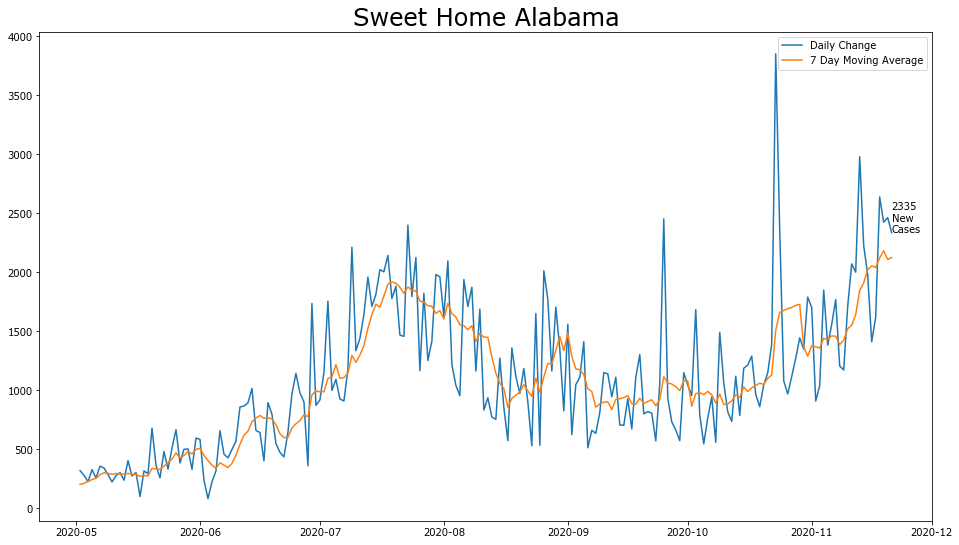

In [23]:
daily_change(alabama_data[50:], 'Sweet Home Alabama')

## Alaska (AK)

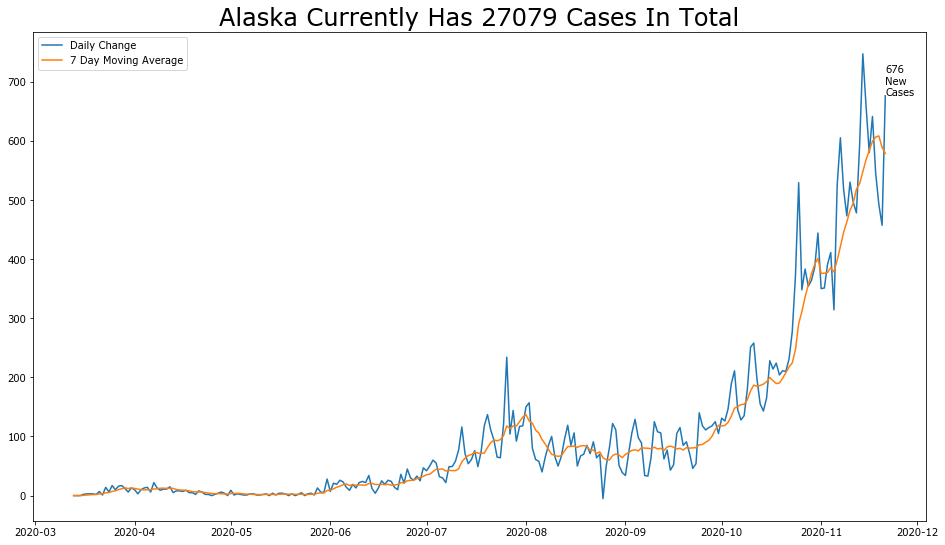

In [24]:
daily_change(alaska_data)

## American Samoa (AS)

In [25]:
# daily_change(american_samoa_data)

## Arizona (AZ)

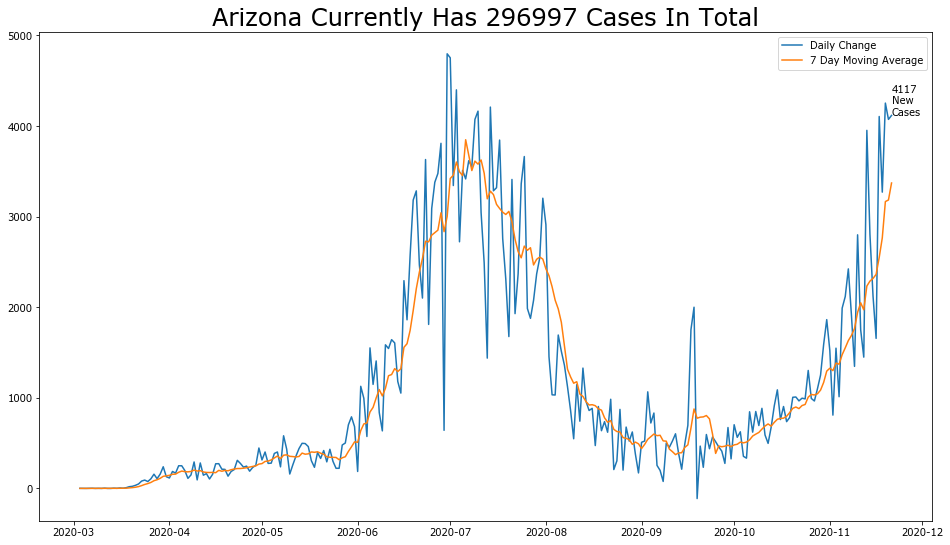

In [26]:
daily_change(arizona_data[37:])

## Arkansas (AR)

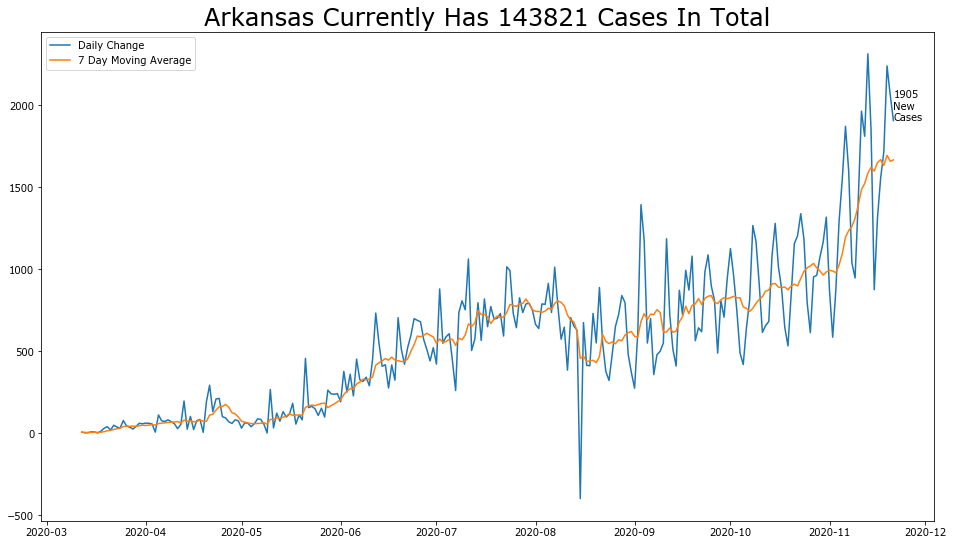

In [27]:
daily_change(arkansas_data)

## California (CA)

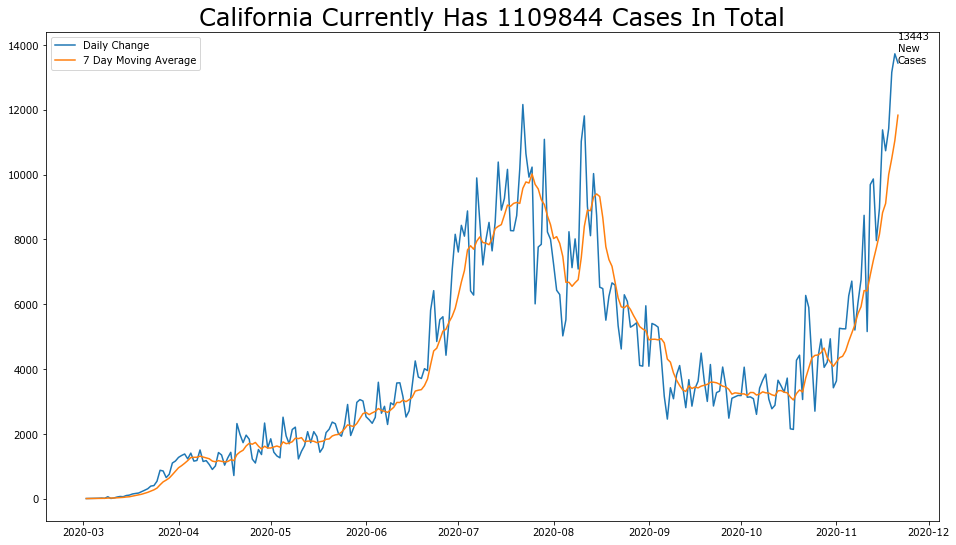

In [28]:
daily_change(california_data[37:])

## Colorado (CO)

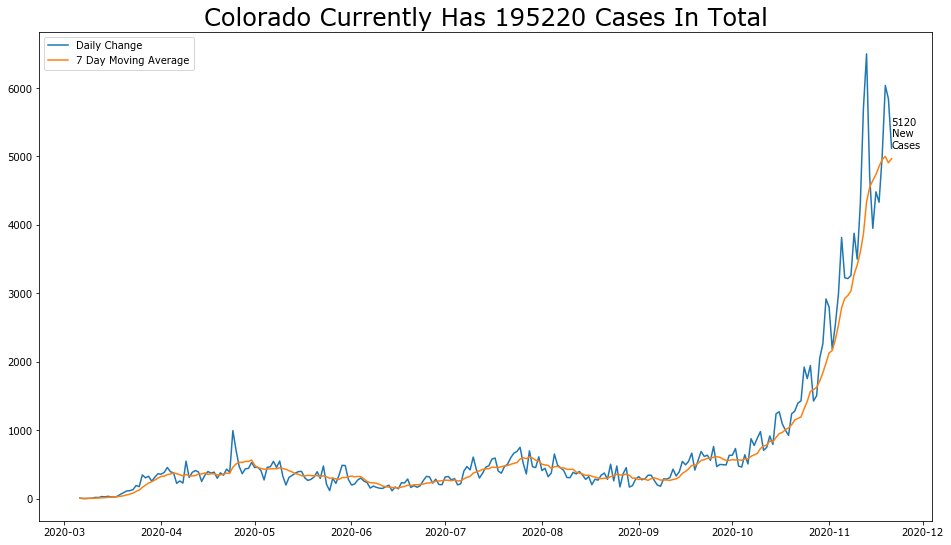

In [29]:
daily_change(colorado_data)

## Connecticut (CT)

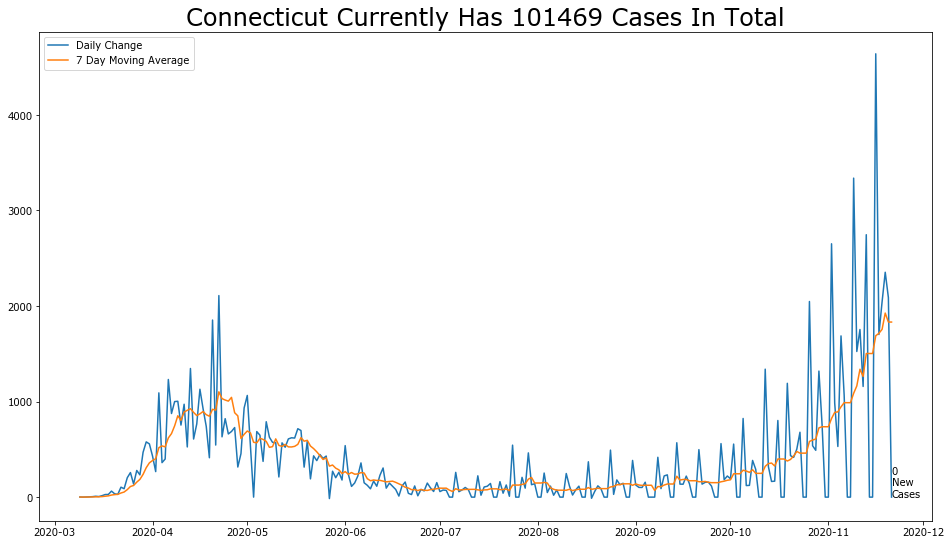

In [30]:
daily_change(connecticut_data)

## Delaware (DE)

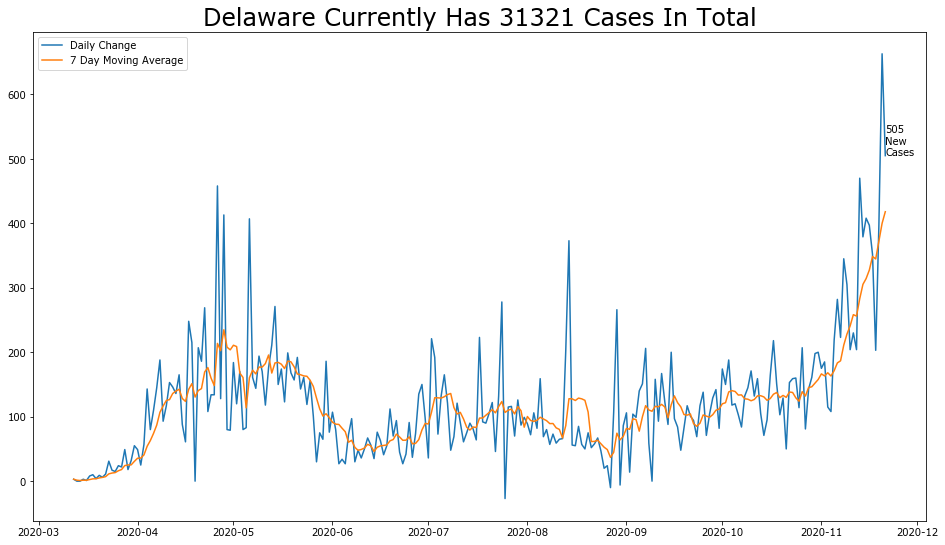

In [31]:
daily_change(delaware_data)

## District of Columbia (DC)

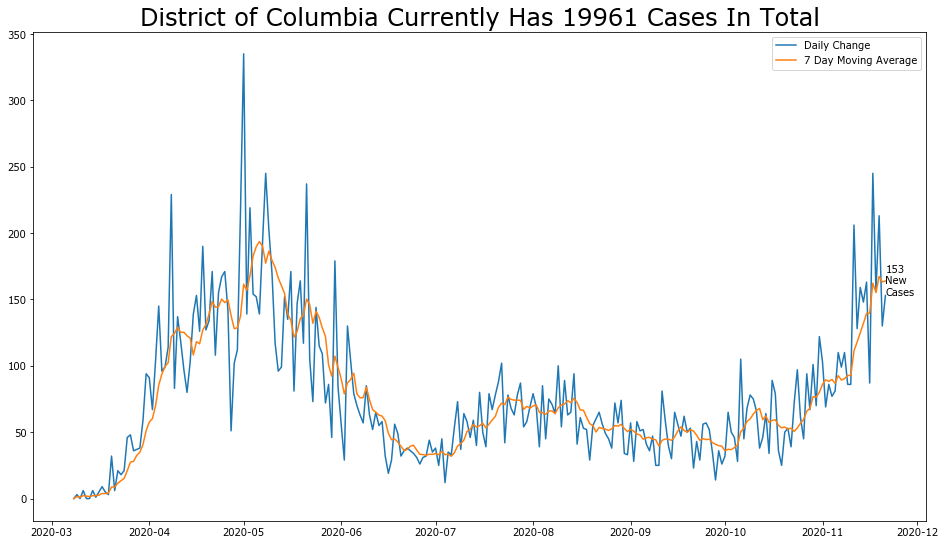

In [32]:
daily_change(dc_data)

## Florida (FL)

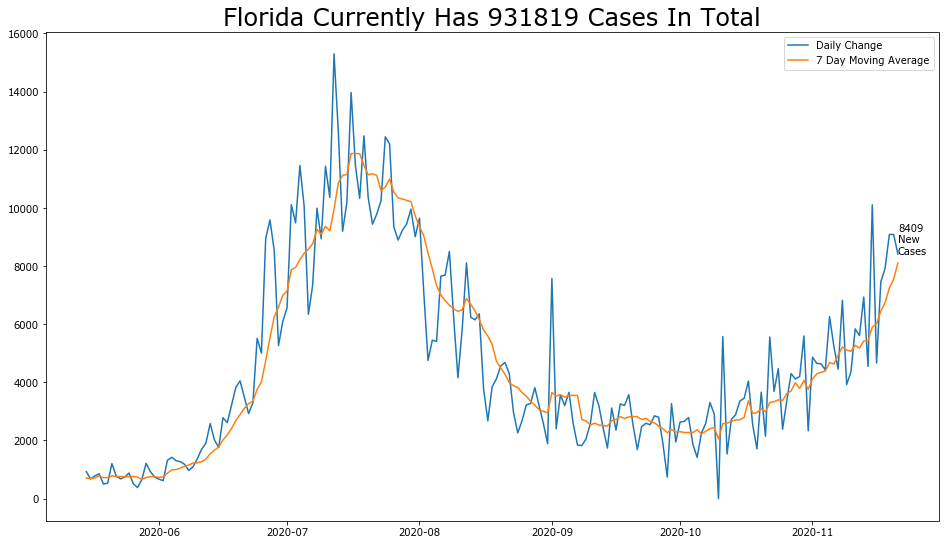

In [33]:
daily_change(florida_data[dt.date(2020, 5, 15):])

## Georgia (GA)

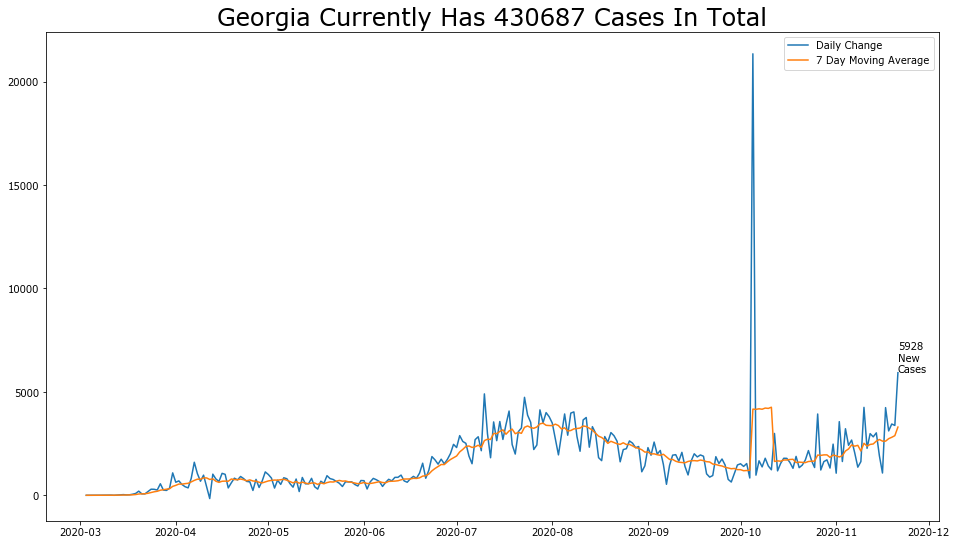

In [34]:
daily_change(georgia_data)

# https://thehill.com/homenews/state-watch/495527-georgia-to-lift-stay-at-home-order-for-most-residents-friday

## Guam (GU)

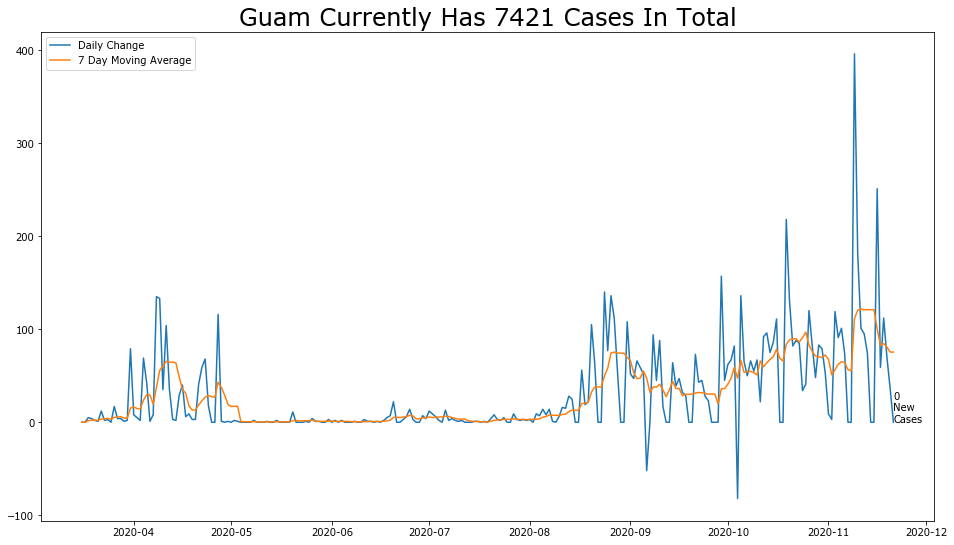

In [35]:
daily_change(guam_data)

## Hawaii (HI)

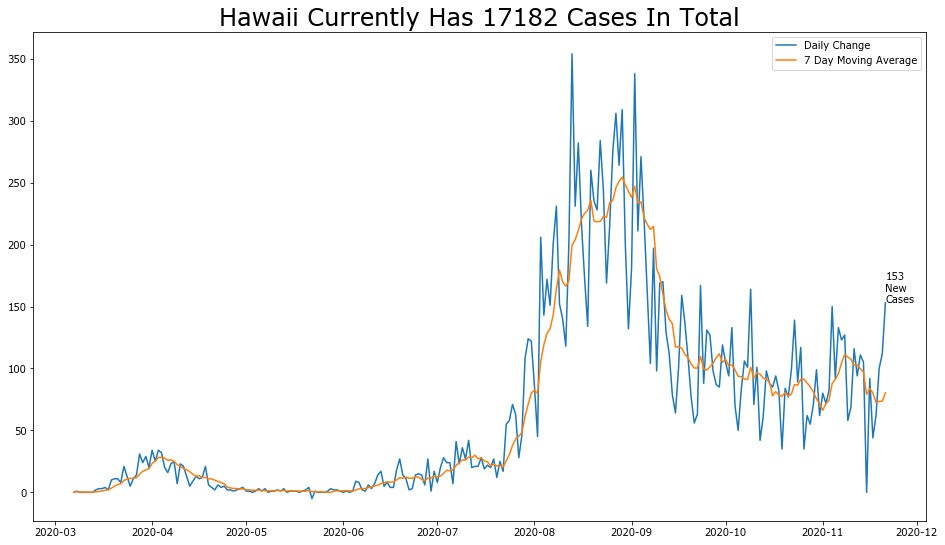

In [36]:
daily_change(hawaii_data)

## Idaho (ID)

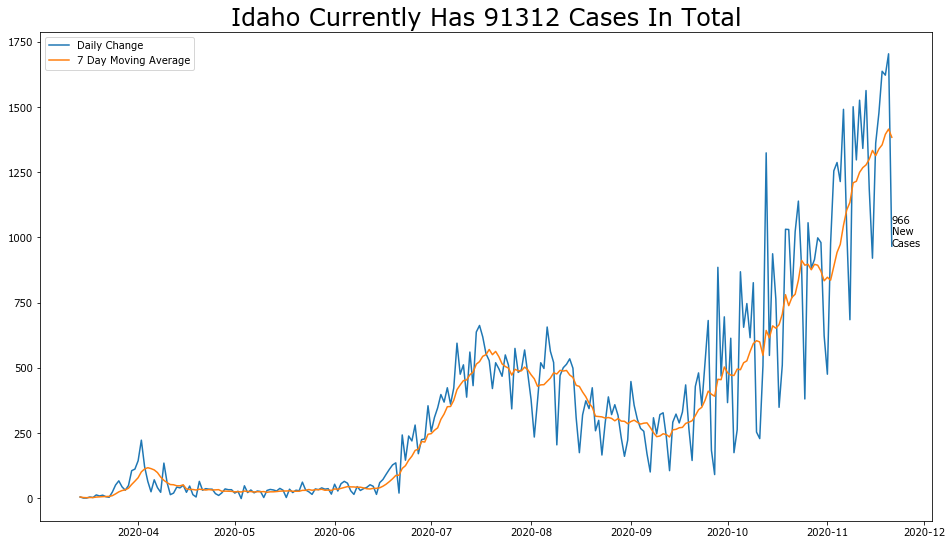

In [37]:
daily_change(idaho_data)

## Illinois (IL)

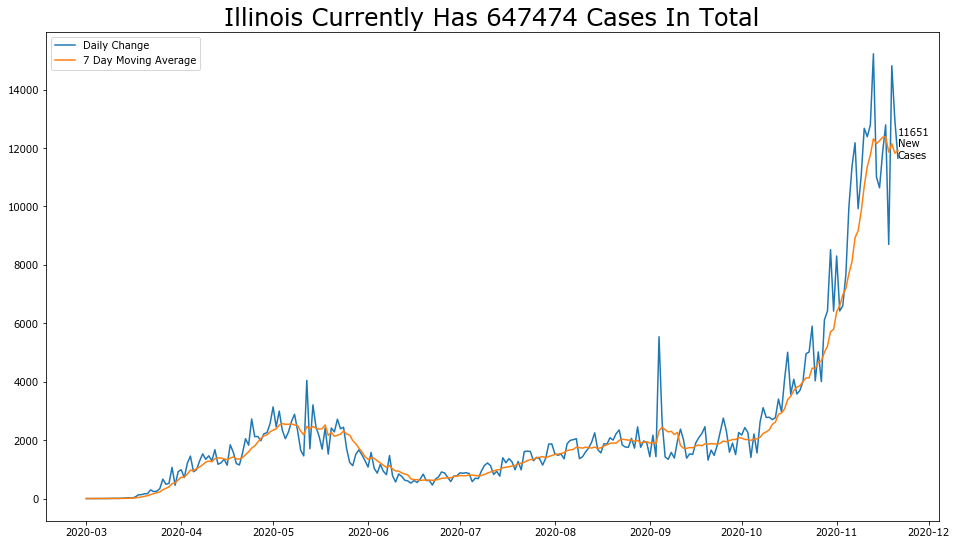

In [38]:
daily_change(illinois_data[37:])

## Indiana (IN)

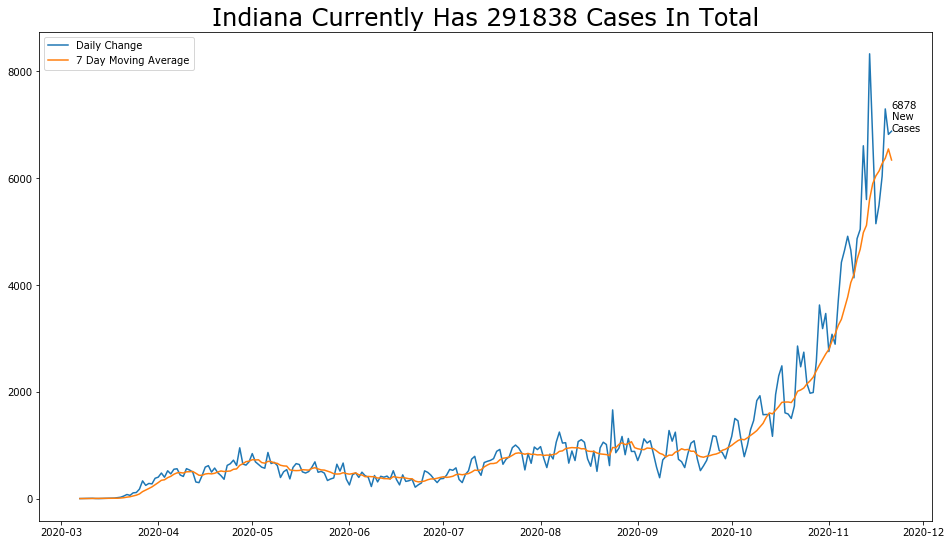

In [39]:
daily_change(indiana_data)

## Iowa (IA)

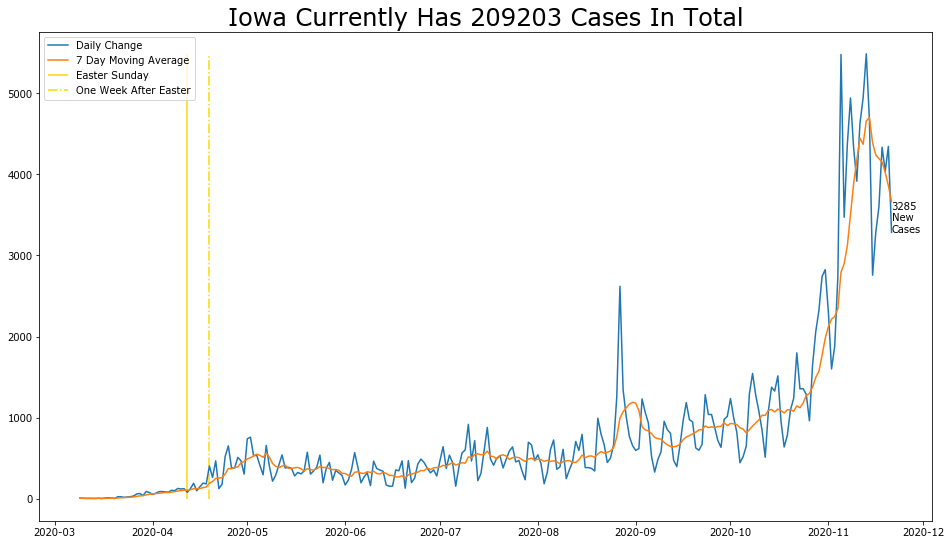

In [40]:
daily_change(iowa_data, easter="Bad")

## Kansas (KS)

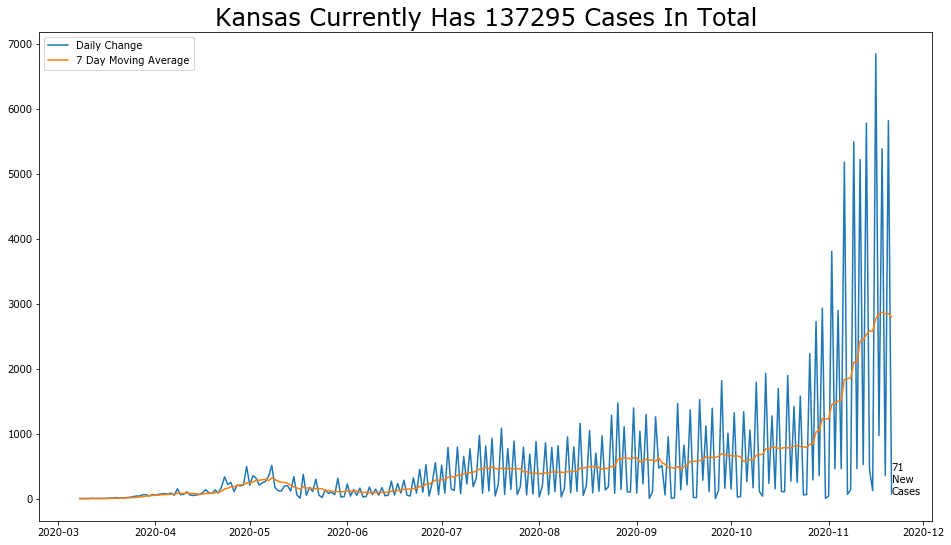

In [41]:
daily_change(kansas_data)

## Kentucky (KY)

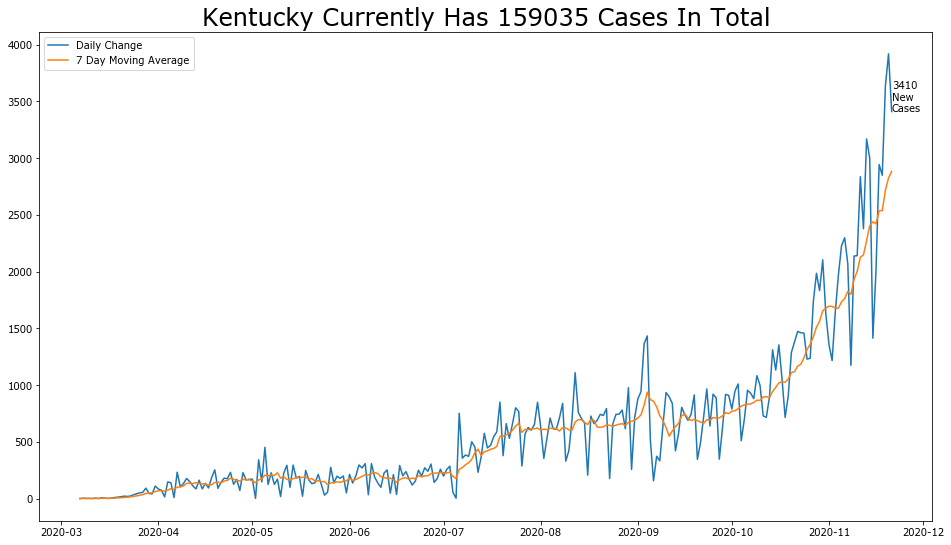

In [42]:
daily_change(kentucky_data)

## Louisiana (LA)

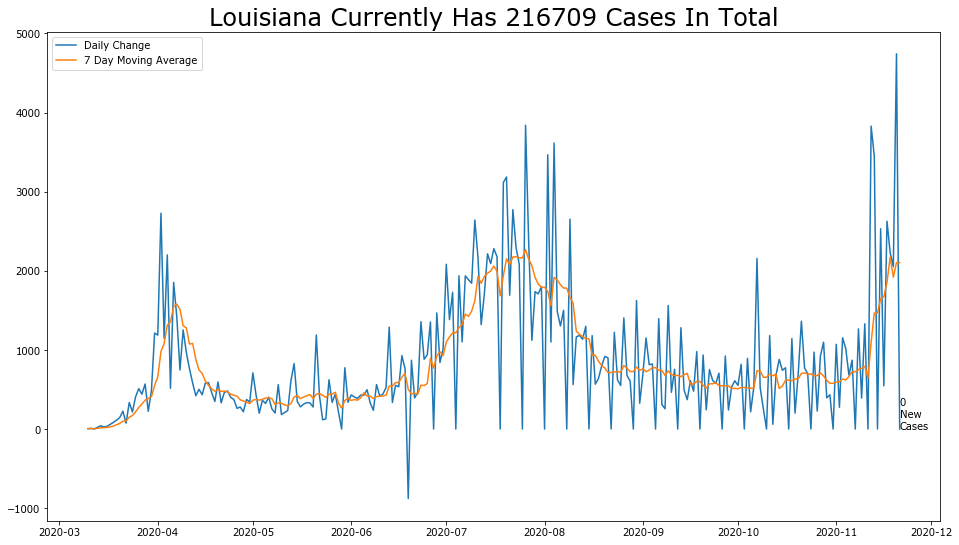

In [43]:
daily_change(louisiana_data)

## Maine (ME)

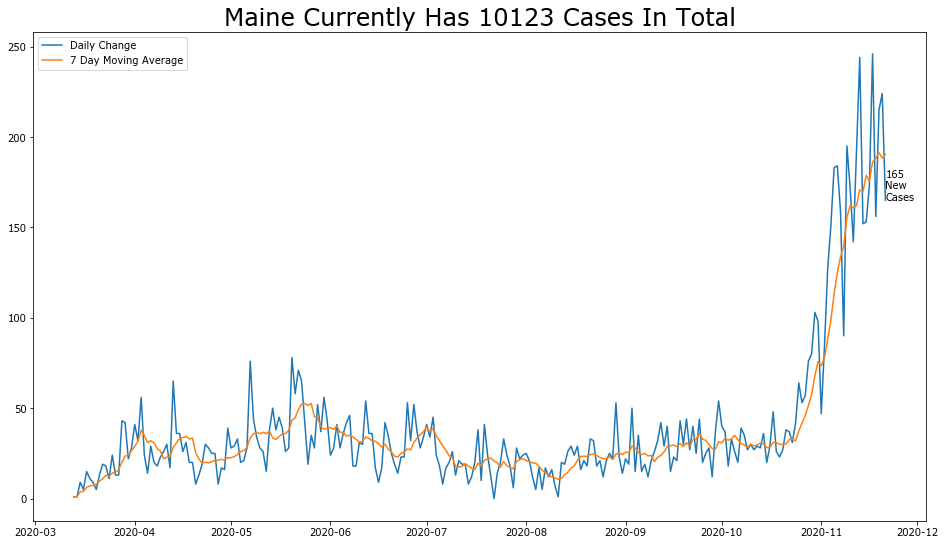

In [44]:
daily_change(maine_data)

## Maryland (MD)

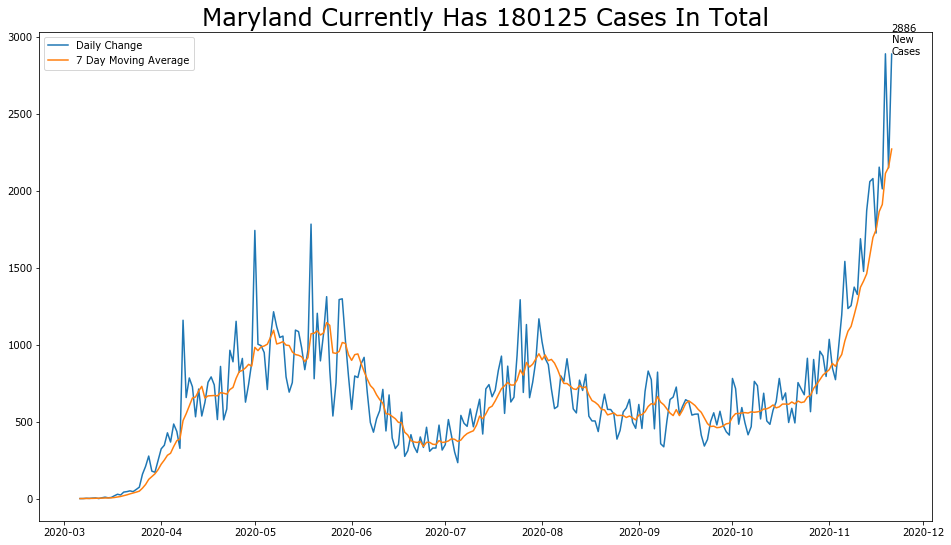

In [45]:
daily_change(maryland_data)

## Massachusetts (MA)

(-10, 5000)

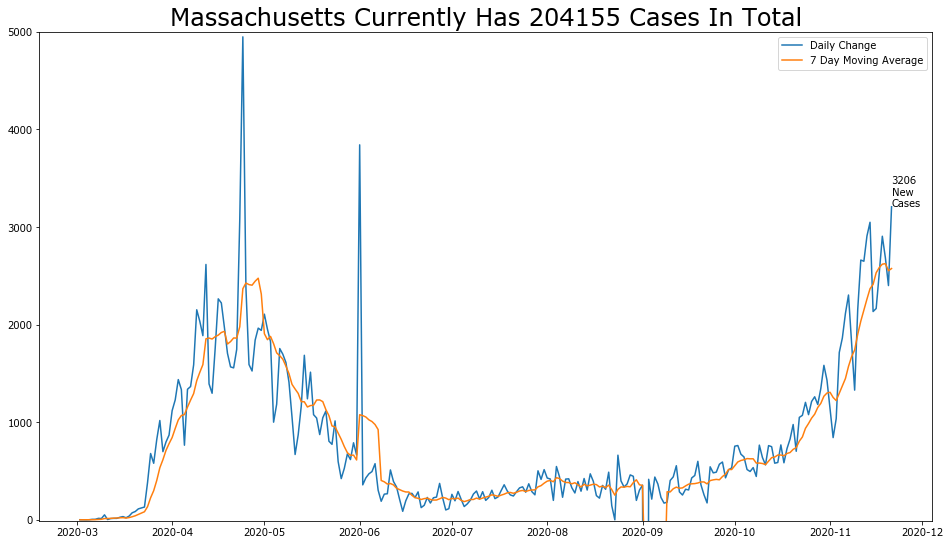

In [46]:
daily_change(massachusetts_data[30:])
plt.ylim(bottom=-10, top=5000)

# Patriots' Day is a local holiday in the state that would usually have a marathon happening during it
# plt.vlines(x=dt.date(2020, 4, 18), ymin=massachusetts_data.change_in_cases.min(), ymax=massachusetts_data.change_in_cases.max(), label="Begining of Patriots' Day Weekend", color='red')
# plt.vlines(x=dt.date(2020, 4, 25), ymin=massachusetts_data.change_in_cases.min(), ymax=massachusetts_data.change_in_cases.max(), label="One Week After Begining of Patriots' Day Weekend", color='red', linestyle='dashdot')

# plt.legend()

## Michigan (MI)

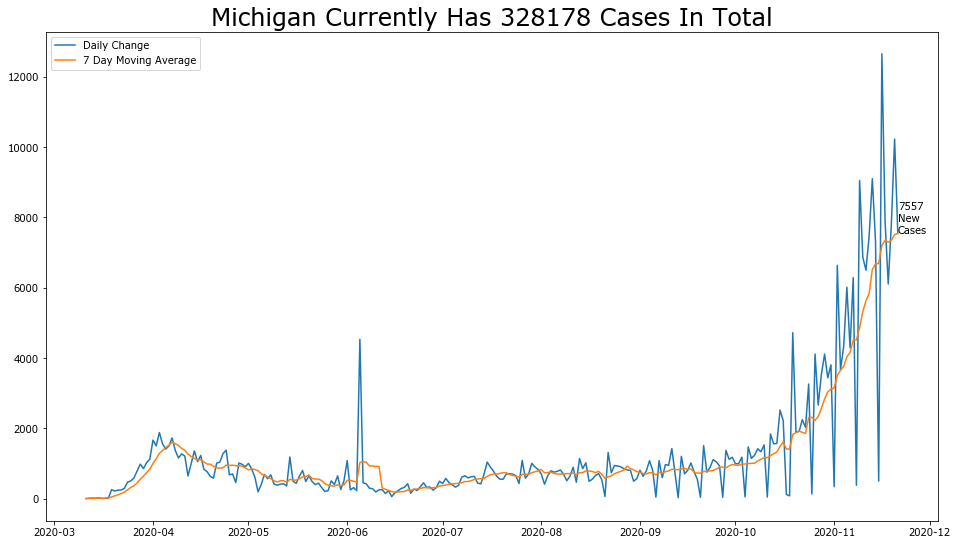

In [47]:
daily_change(michigan_data)

## Minnesota (MN)

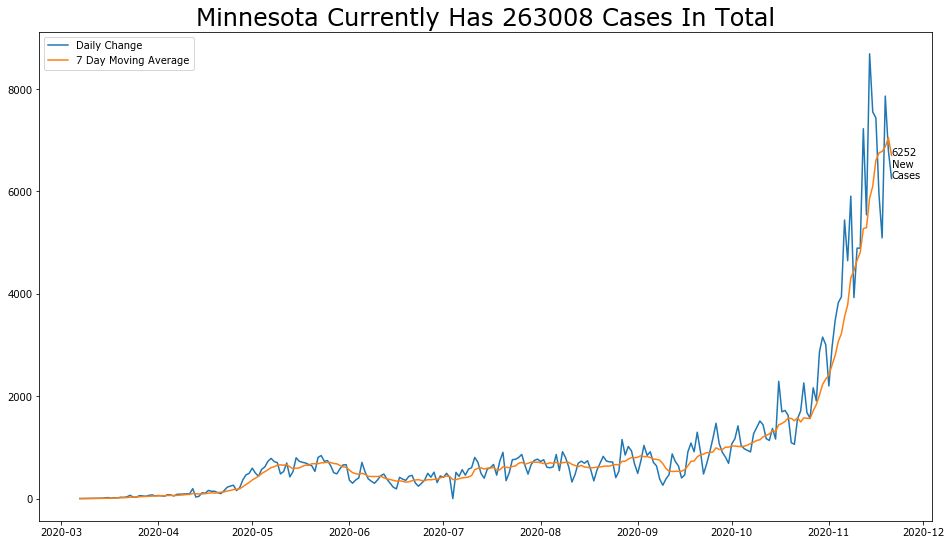

In [48]:
daily_change(minnesota_data)

## Mississippi (MS)

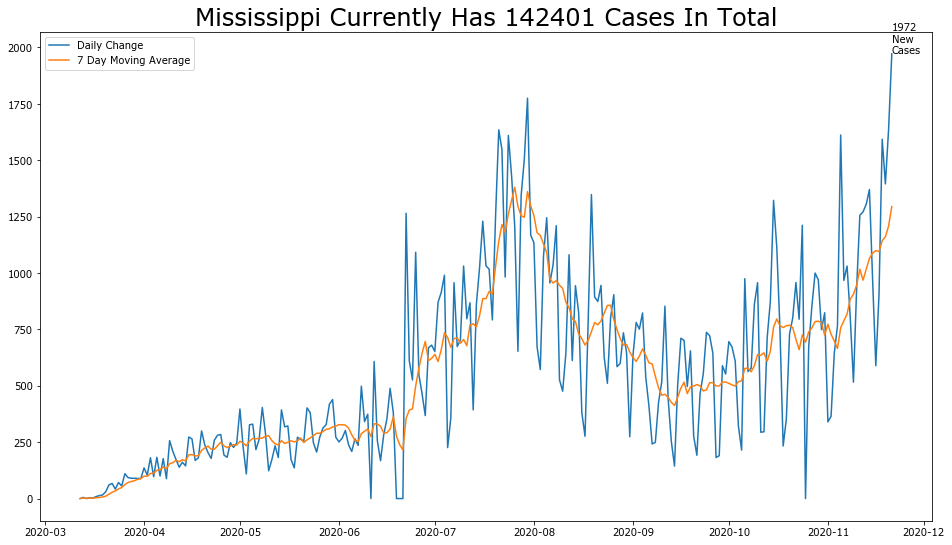

In [49]:
daily_change(mississippi_data)

## Missouri (MO)

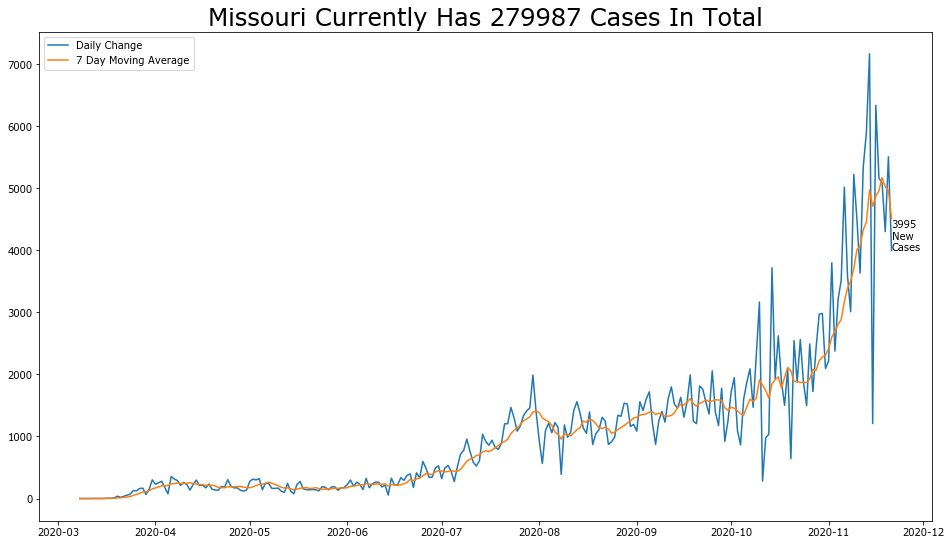

In [50]:
daily_change(missouri_data)

## Montana (MT)

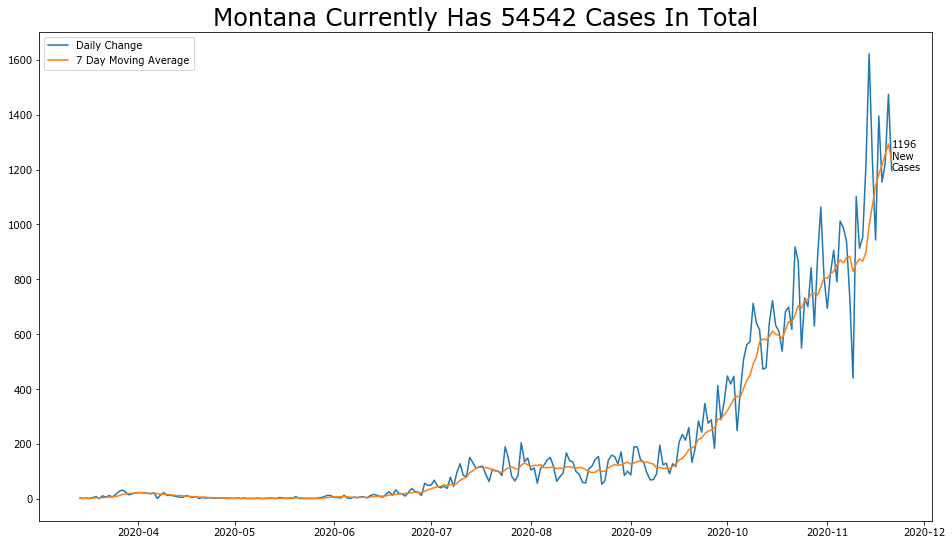

In [51]:
daily_change(montana_data)

## Nebraska (NE)

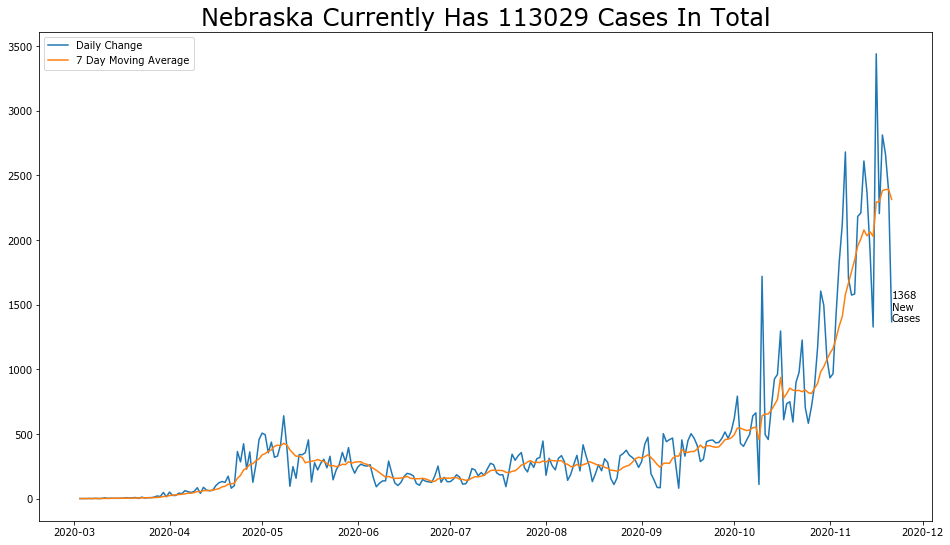

In [52]:
daily_change(nebraska_data[15:])

## Nevada (NV)

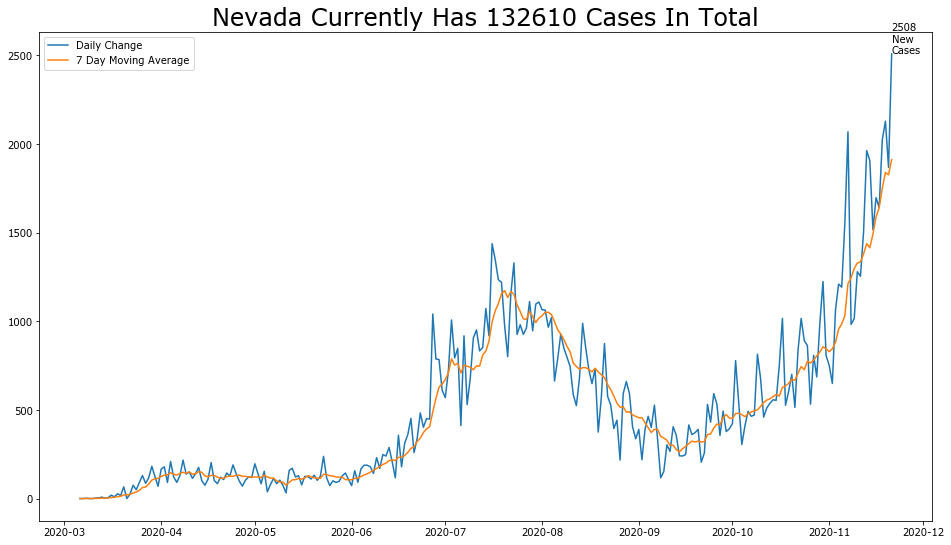

In [53]:
daily_change(nevada_data)

## New Hampshire (NH)

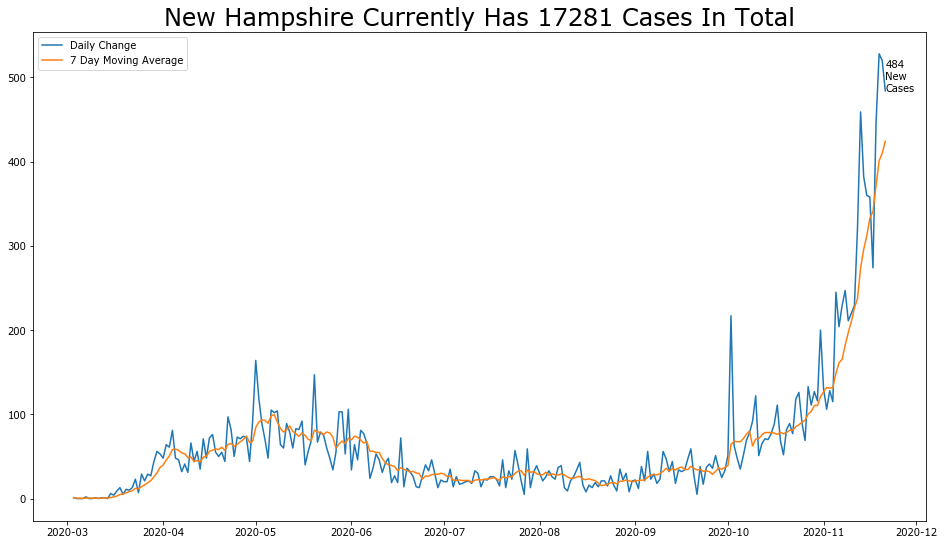

In [54]:
daily_change(new_hampshire_data)

## New Jersey (NJ)

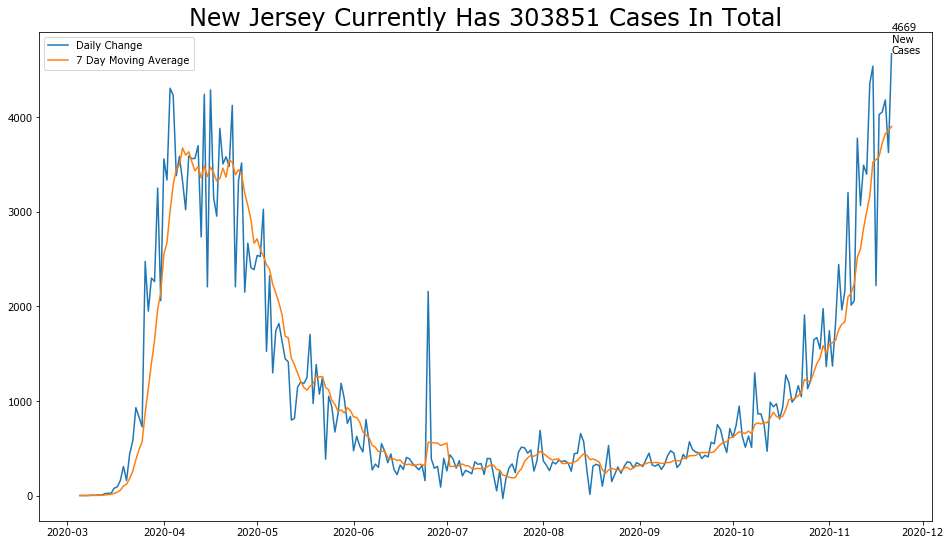

In [55]:
daily_change(new_jersey_data)

## New Mexico (NM)

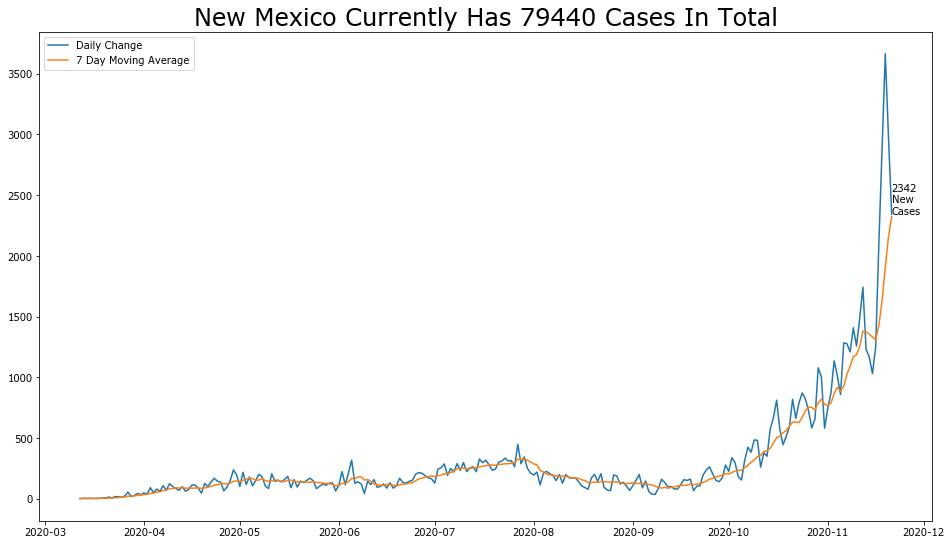

In [56]:
daily_change(new_mexico_data)

## New York (NY)

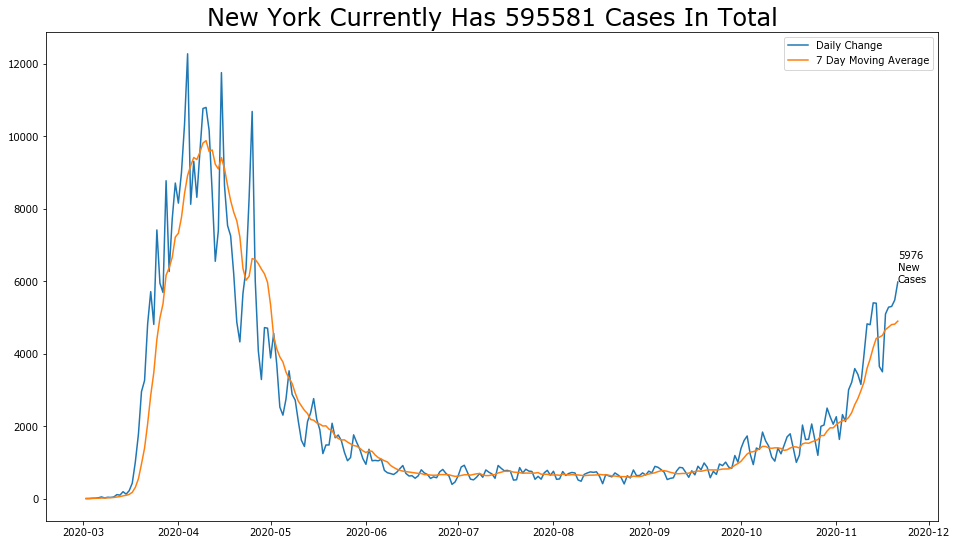

In [57]:
daily_change(new_york_data)

## North Carolina (NC)

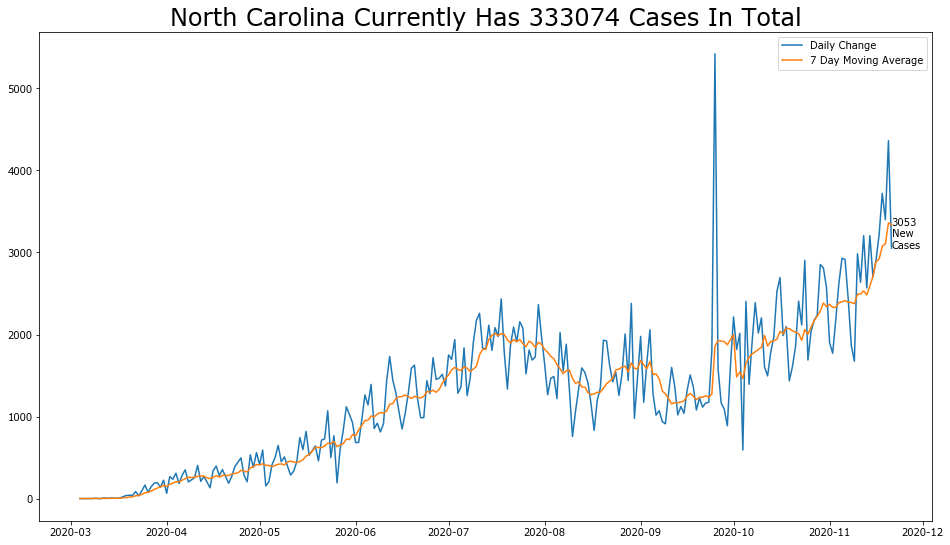

In [58]:
daily_change(north_carolina_data)

## North Dakota (ND)

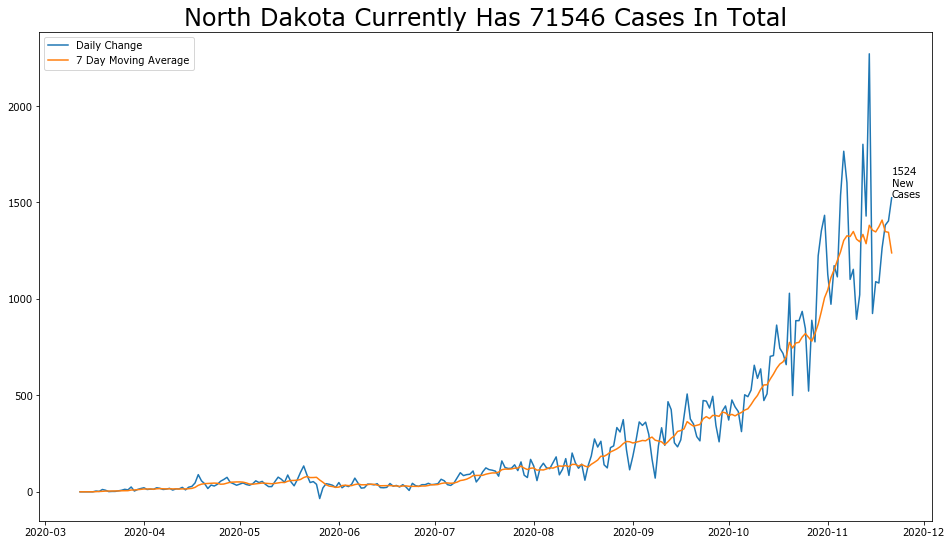

In [59]:
daily_change(north_dakota_data)

## Northern Mariana Islands (MP)

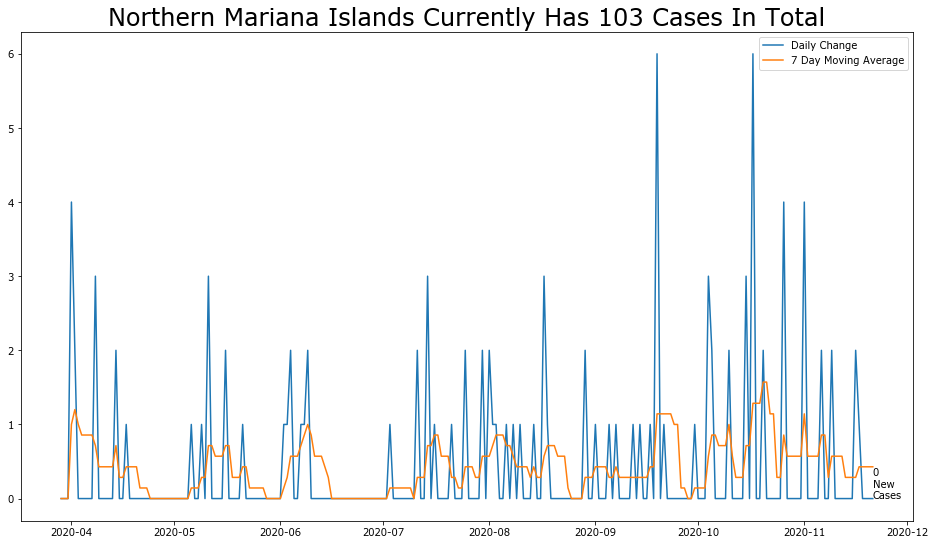

In [60]:
daily_change(north_mariana_islands_data)

## Ohio (OH)

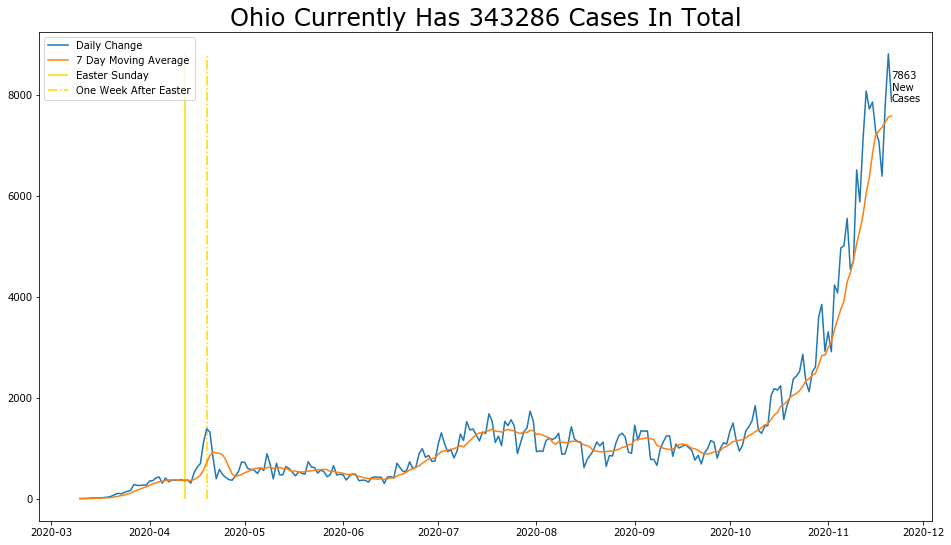

In [61]:
daily_change(ohio_data, easter='Oh Oh')

## Oklahoma (OK)

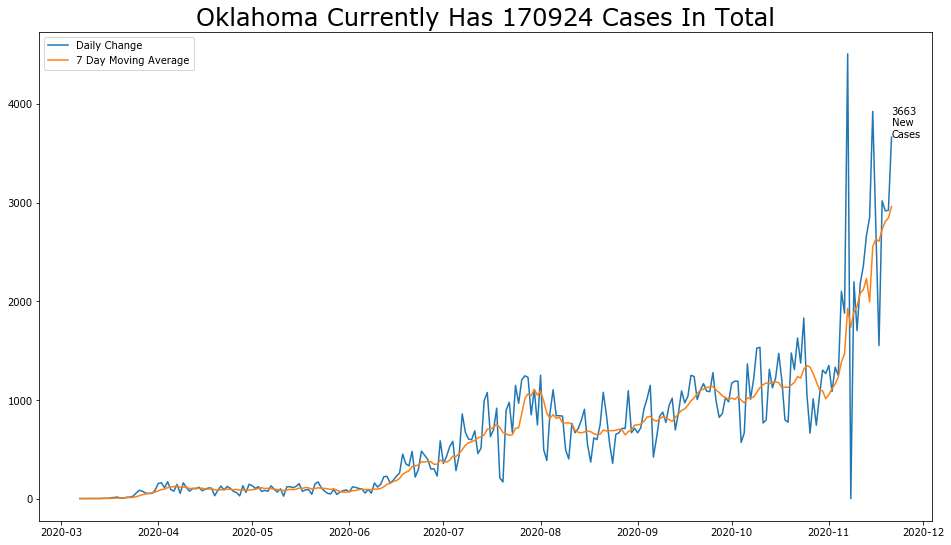

In [62]:
daily_change(oklahoma_data)

## Oregon (OR)

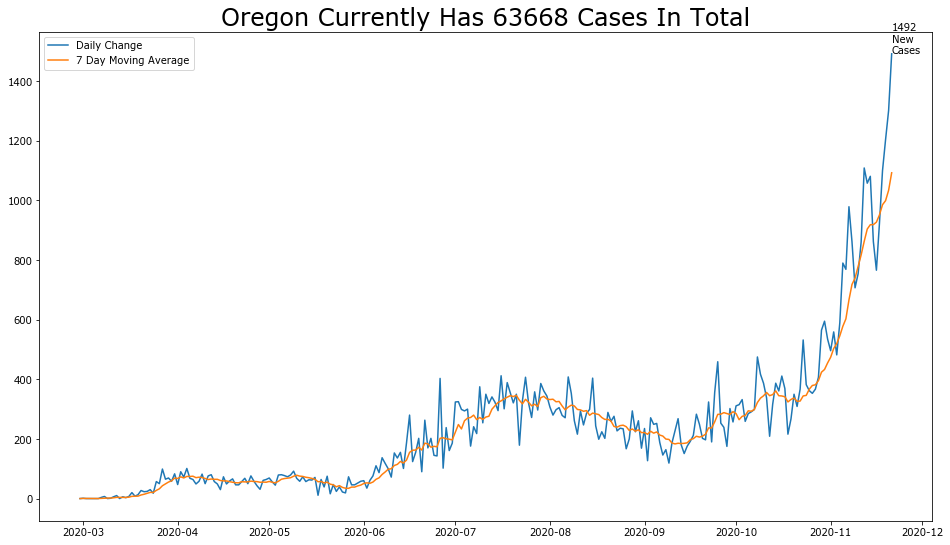

In [63]:
daily_change(oregon_data)

## Pennsylvania (PA)

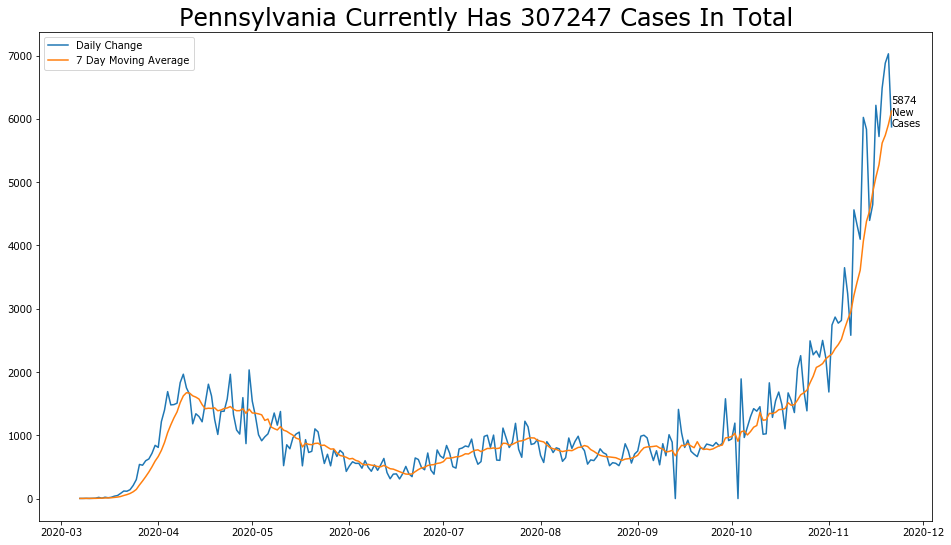

In [64]:
daily_change(pennsylvania_data)

## Puerto Rico (PR)

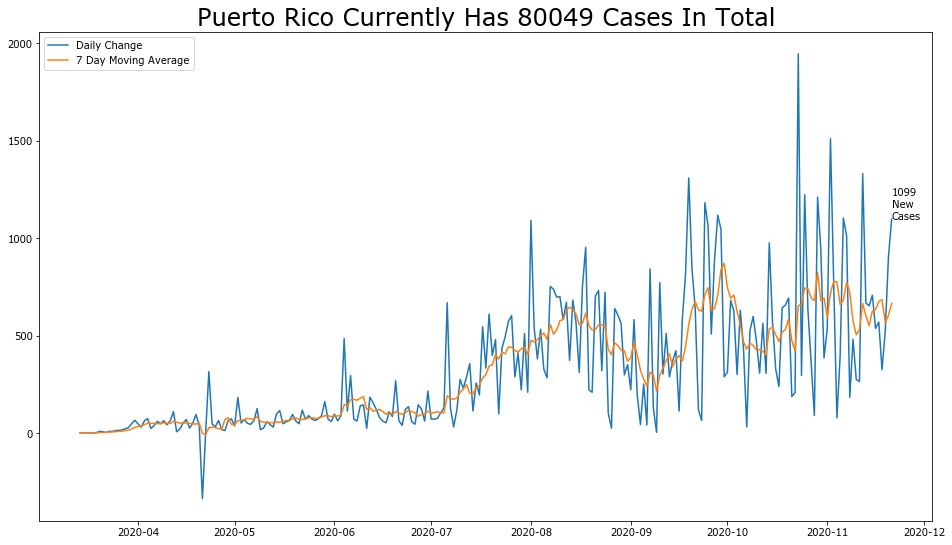

In [65]:
daily_change(puerto_rico_data)

## Rhode Island (RI)

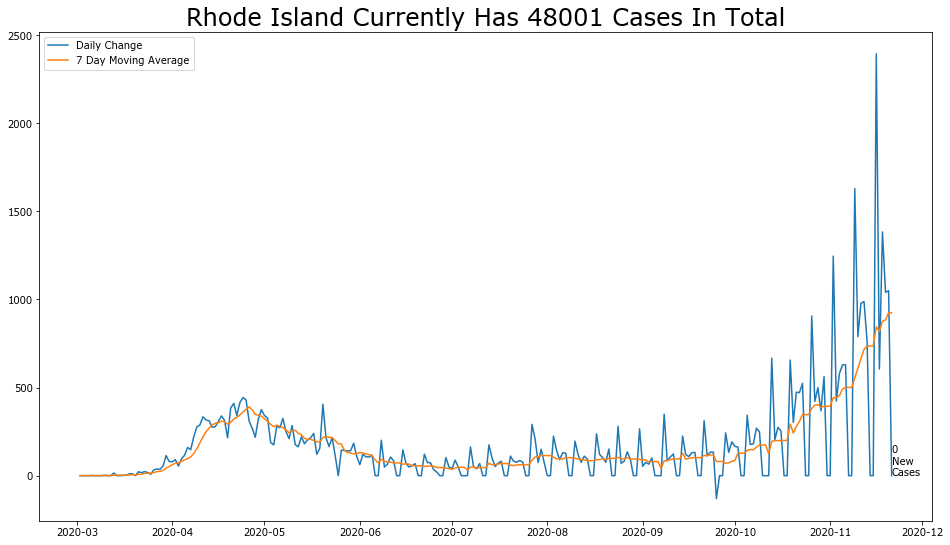

In [66]:
daily_change(rhode_island_data)

## South Carolina (SC)

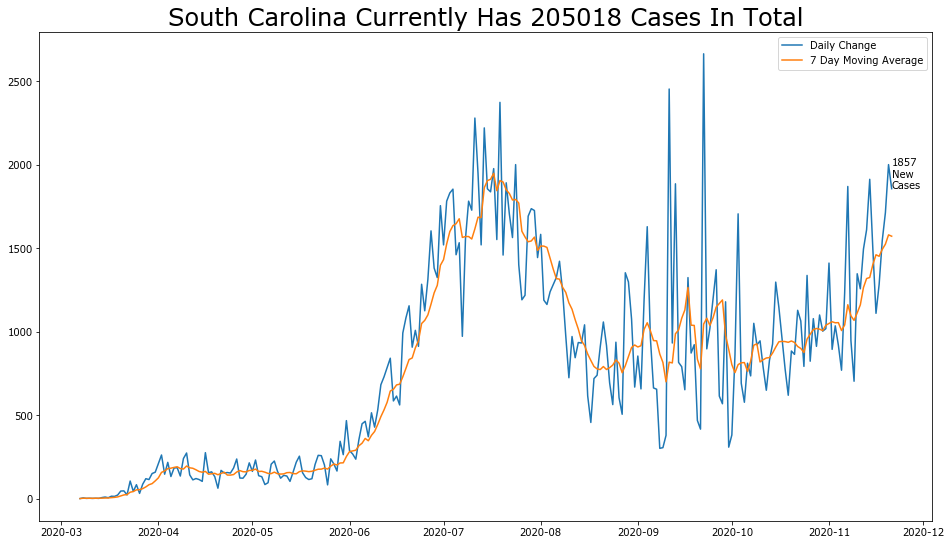

In [67]:
daily_change(south_carolina_data)

## South Dakota (SD)

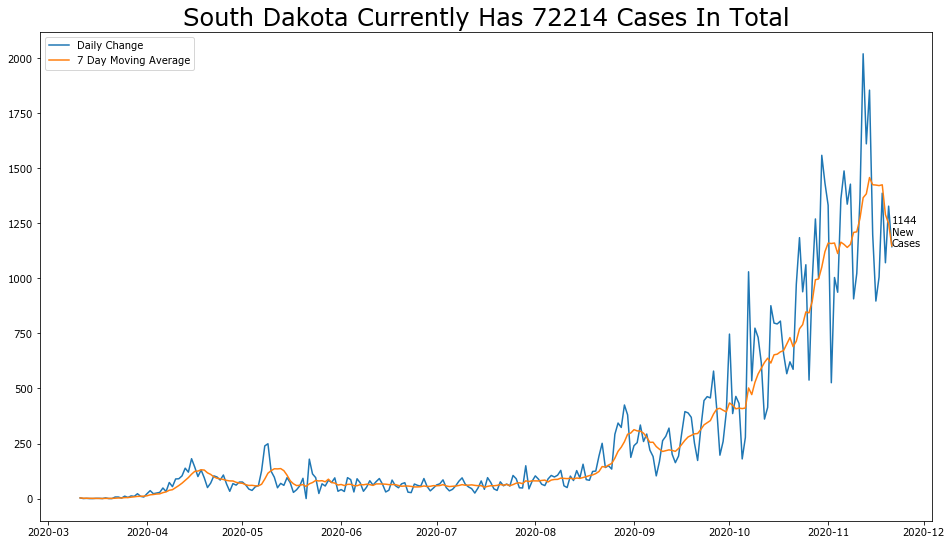

In [68]:
daily_change(south_dakota_data)

## Tennessee (TN)

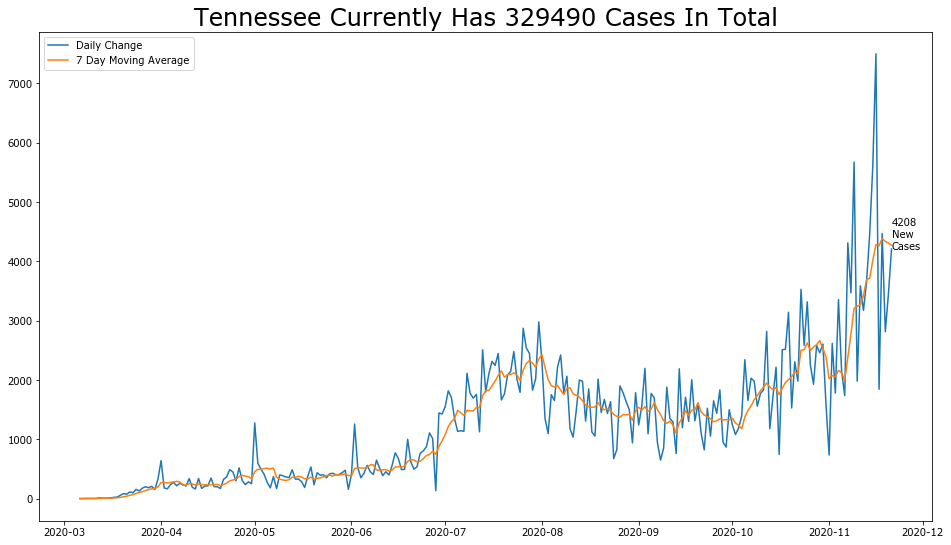

In [69]:
daily_change(tennessee_data)

## Texas (TX)

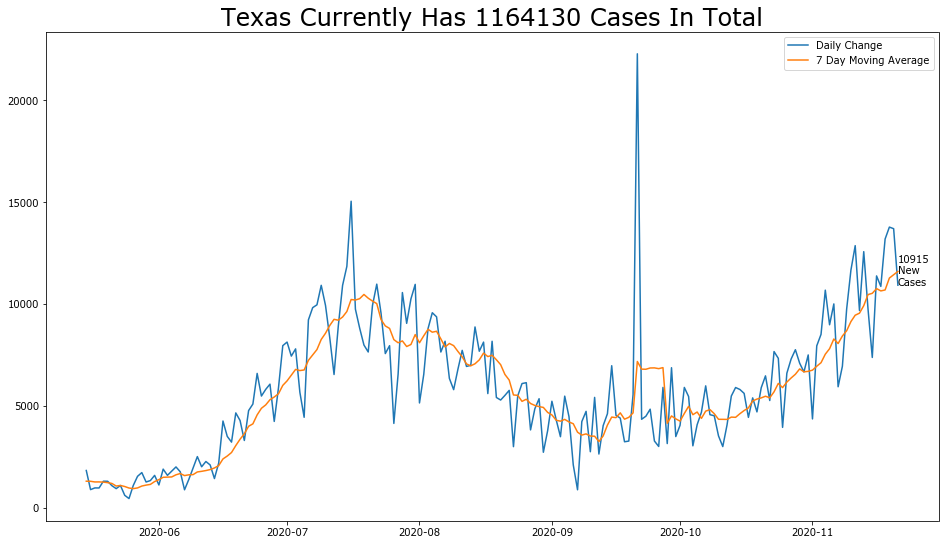

In [70]:
daily_change(texas_data[dt.date(2020, 5, 15):])

## Utah (UT)

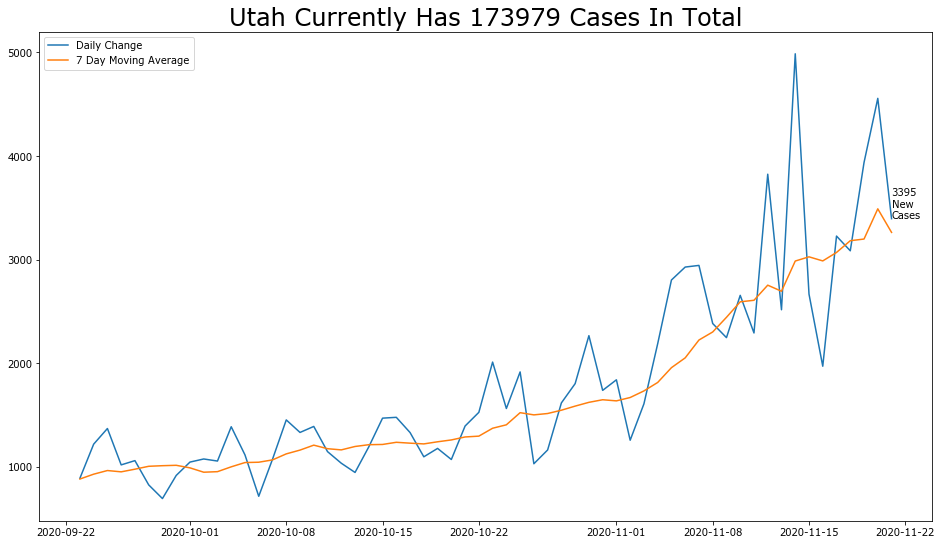

In [71]:
daily_change(utah_data[-60:])

## Vermont (VT)

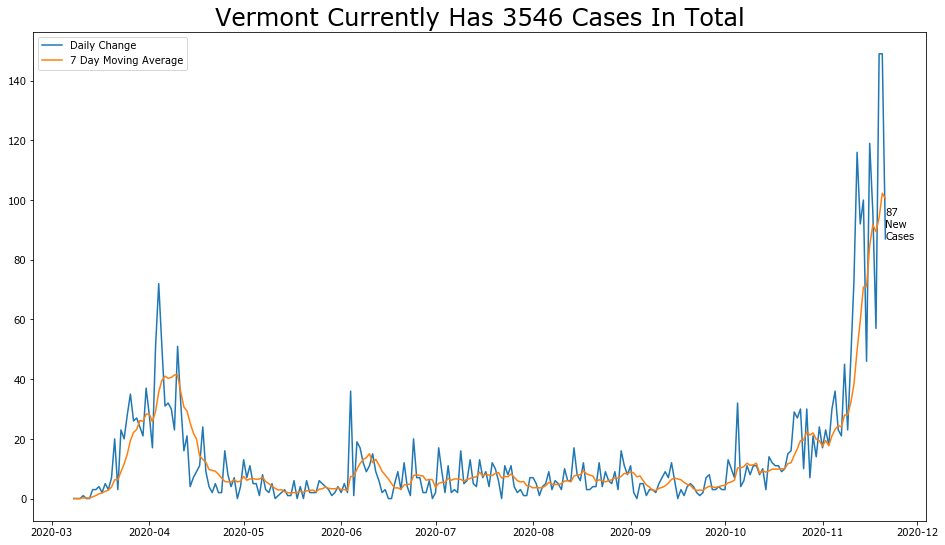

In [72]:
daily_change(vermont_data)

## Virgin Islands (VI)

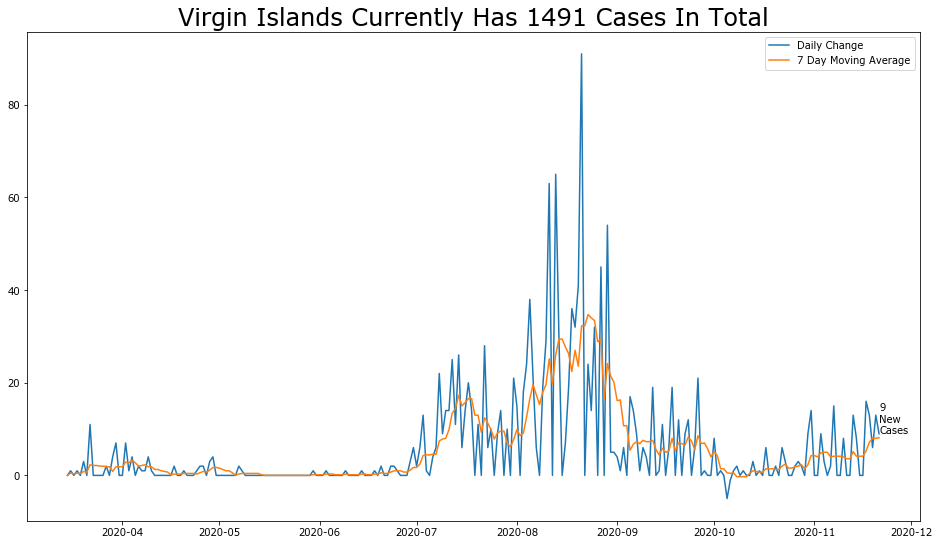

In [73]:
daily_change(virgin_islands_data)

## Virginia (VA)

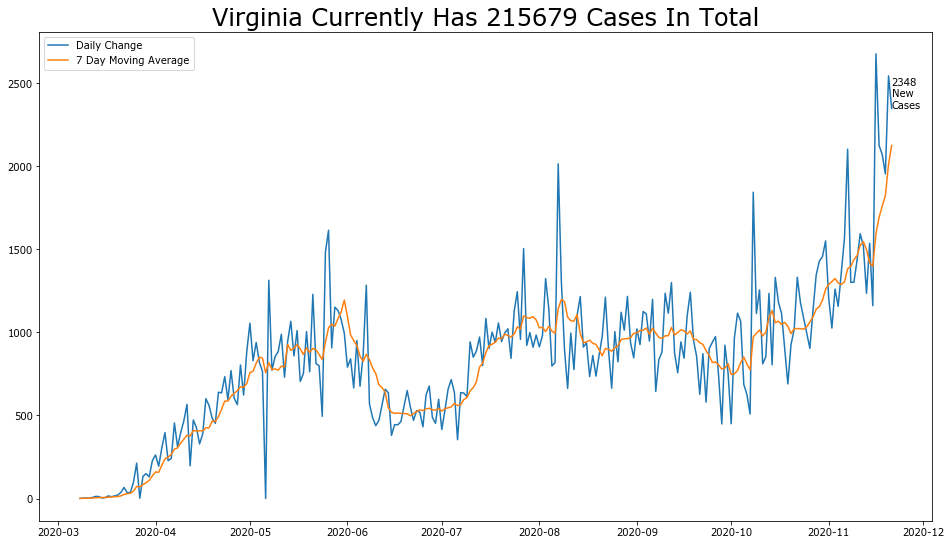

In [74]:
daily_change(virginia_data)

## Washington (WA)

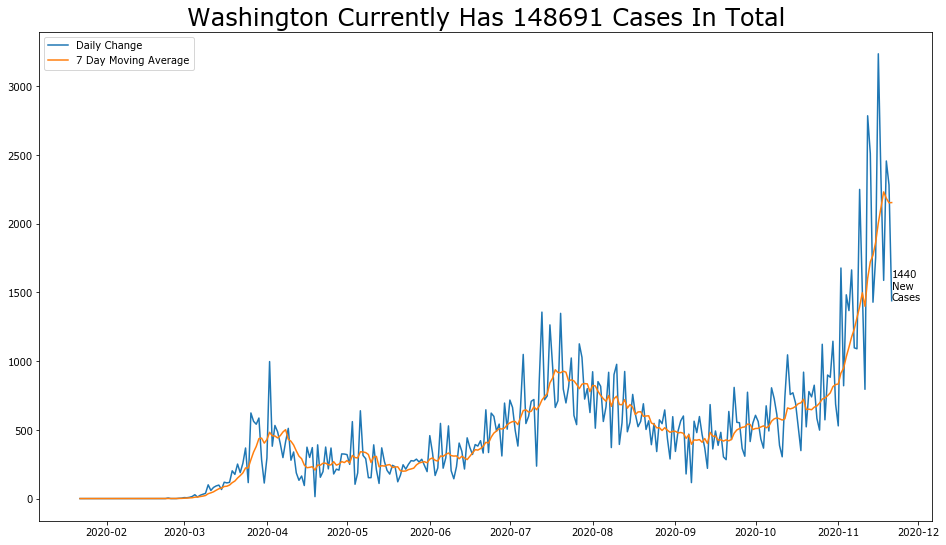

In [75]:
daily_change(washington_data)

## West Virginia (WV)

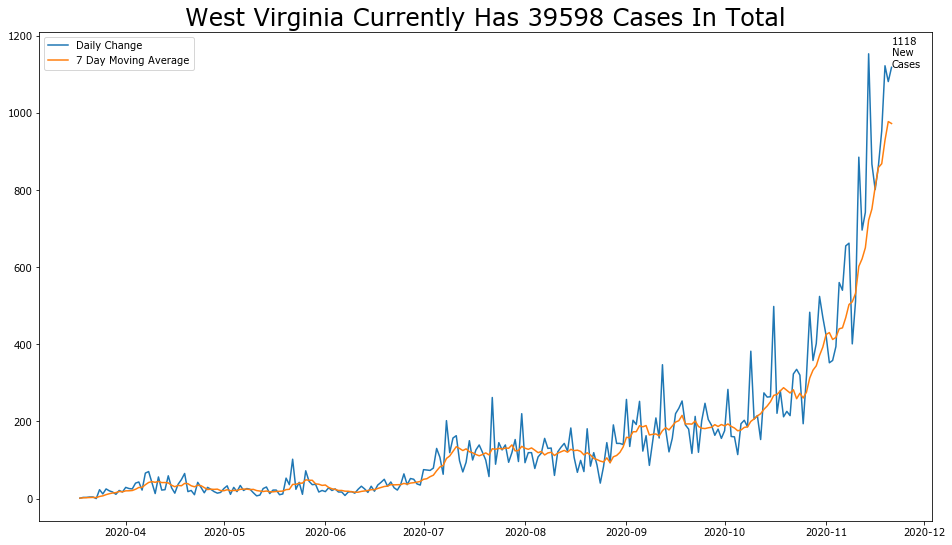

In [76]:
daily_change(west_virginia_data)

## Wisconsin (WI)

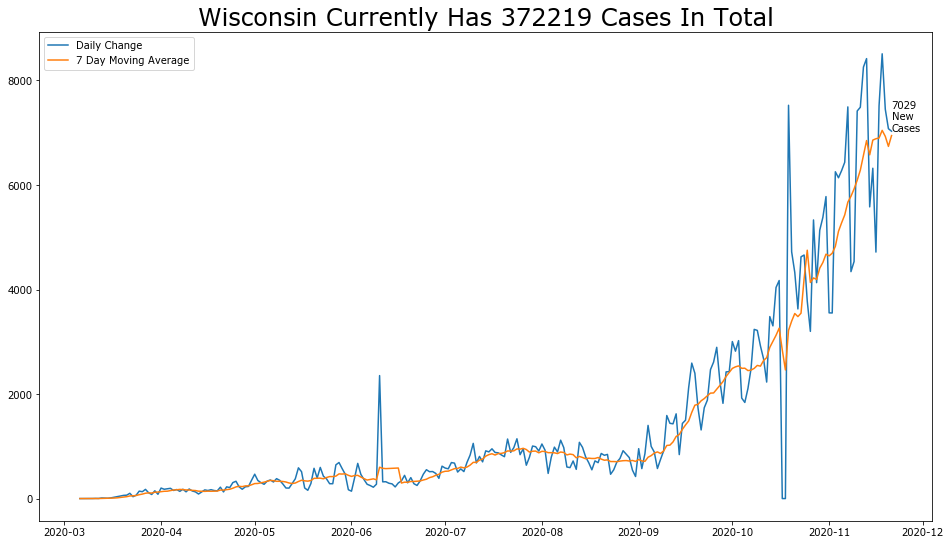

In [77]:
daily_change(wisconsin_data[30:])
# plt.vlines(x=dt.date(2020, 5, 13), ymin=wisconsin_data['change_in_cases'].min(), ymax=wisconsin_data['change_in_cases'].max(), color='red', label='Stay At Home Order Overturned')
# plt.vlines(x=dt.date(2020, 5, 20), ymin=wisconsin_data['change_in_cases'].min(), ymax=wisconsin_data['change_in_cases'].max(), linestyle='dashdot', color='red', label='One Week After Overturn')
plt.legend();

## Wyoming (WY)

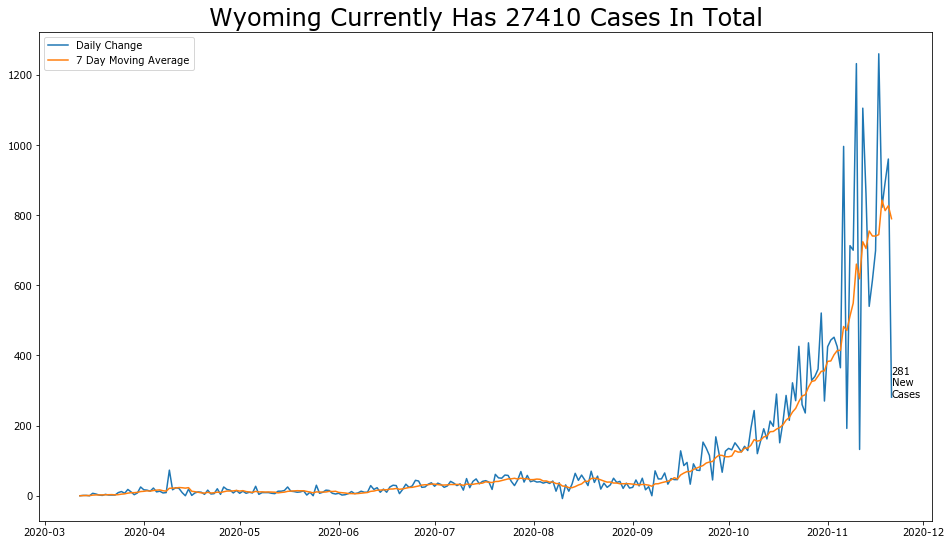

In [78]:
daily_change(wyoming_data)

## Full Nation

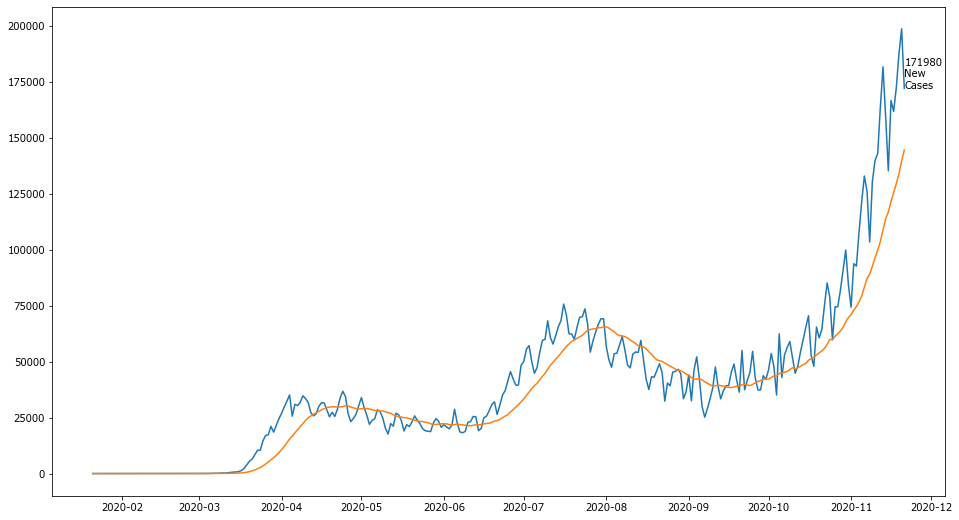

In [79]:
plt.figure(figsize=(16,9))
plt.plot(total_us_data.groupby(['date']).sum()['change_in_cases'])
plt.text(x=total_us_data.date.tail(1), y=total_us_data.groupby(['date']).sum()['change_in_cases'][-1], s=f"{int(total_us_data.groupby(['date']).sum()['change_in_cases'][-1])}\nNew\nCases");
plt.plot(total_us_data.groupby(['date']).sum()['change_in_cases'].transform(lambda x: x.rolling(20, 1).mean()))
plt.show()

## States with Most Cases

In [80]:
total_us_data.groupby(total_us_data.state).last().sort_values(by='change_in_cases', ascending=False)

date  fips    cases  deaths  percent_change  \
state                                                                        
California               2020-11-21     6  1109844   18709        0.012261   
Illinois                 2020-11-21    17   647474   11967        0.018324   
Texas                    2020-11-21    48  1164130   21004        0.009465   
Florida                  2020-11-21    12   931819   17929        0.009106   
Ohio                     2020-11-21    39   343286    5984        0.023442   
Michigan                 2020-11-21    26   328178    8874        0.023570   
Wisconsin                2020-11-21    55   372219    3155        0.019248   
Indiana                  2020-11-21    18   291838    5246        0.024137   
Minnesota                2020-11-21    27   263008    3257        0.024350   
New York                 2020-11-21    36   595581   33737        0.010136   
Georgia                  2020-11-21    13   430687    8940        0.013956   
Pennsylvania             2020-11-21    42   307247    9862        0.019491   
Colorado                 2020-11-21     8   195220    2791        0.026933   
New Jersey               2020-11-21    34   303851   16746        0.015606   
Tennessee                2020-11-21    47   329490    4163        0.012936   
Arizona                  2020-11-21     4   296997    6459        0.014057   
Missouri                 2020-11-21    29   279987    3684        0.014475   
Oklahoma                 2020-11-21    40   170924    1624        0.021900   
Kentucky                 2020-11-21    21   159035    1886        0.021912   
Utah                     2020-11-21    49   173979     789        0.019902   
Iowa                     2020-11-21    19   209203    2191        0.015953   
Massachusetts            2020-11-21    25   204155   10488        0.015954   
North Carolina           2020-11-21    37   333074    5035        0.009251   
Maryland                 2020-11-21    24   180125    4415        0.016283   
Nevada                   2020-11-21    32   132610    2017        0.019277   
Virginia                 2020-11-21    51   215679    3938        0.011006   
New Mexico               2020-11-21    35    79440    1352        0.030377   
Alabama                  2020-11-21     1   230708    3457        0.010225   
Mississippi              2020-11-21    28   142401    3657        0.014043   
Arkansas                 2020-11-21     5   143821    2337        0.013423   
South Carolina           2020-11-21    45   205018    4274        0.009141   
North Dakota             2020-11-21    38    71546     840        0.021765   
Oregon                   2020-11-21    41    63668     822        0.023996   
Washington               2020-11-21    53   148691    2738        0.009779   
Nebraska                 2020-11-21    31   113029     929        0.012251   
Montana                  2020-11-21    30    54542     604        0.022420   
South Dakota             2020-11-21    46    72214     777        0.016097   
West Virginia            2020-11-21    54    39598     658        0.029054   
Puerto Rico              2020-11-21    72    80049    1012        0.013920   
Idaho                    2020-11-21    16    91312     851        0.010692   
Alaska                   2020-11-21     2    27079      95        0.025603   
Delaware                 2020-11-21    10    31321     746        0.016388   
New Hampshire            2020-11-21    33    17281     508        0.028815   
Wyoming                  2020-11-21    56    27410     176        0.010358   
Maine                    2020-11-21    23    10123     174        0.016570   
Hawaii                   2020-11-21    15    17182     229        0.008985   
District of Columbia     2020-11-21    11    19961     670        0.007724   
Vermont                  2020-11-21    50     3546      63        0.025152   
Kansas                   2020-11-21    20   137295    1410        0.000517   
Virgin Islands           2020-11-21    78     1491   